__File: operator_evolution_fig.ipynb__

__Author:   A. J. Tropiano (tropiano.4@osu.edu)__<br/>
__Date:     Jan 07, 2020__

This notebook creates figures for _Operator evolution from the similarity renormalization group and the Magnus expansion_. Each function creates or returns values for a calculation. Use the cells below functions to run functions and save figures to the __Figures/Operator_evolution__ folder.

__Revision history:<br/>__
* Jan 07, 2020 - Created by combining several Jupyter notebooks: srg_potentials_fig.ipynb, srg_observables_fig.ipynb, srg_operators_fig.ipynb, and magnus_fig.ipynb. Note, these notebooks are in Old_codes.
* Jan 22, 2020 - Added universality_test function.
* Feb 05, 2020 - Added functions that look at the SRG unitary transformations directly.
* Feb 26, 2020 - Updating functionality of the notebook. Functions will now return f, ax. Add extra labels outside the functions in cells below.
* Apr 09, 2020 - Added function that looks at ratio of SRG transformations to see factorization.
* May 11, 2020 - Changed the SRG transformation contours function to look at generators simultaneously getting rid of the log-scale row.
* Jun 02, 2020 - Using smeared $\delta$ functions in $a^{\dagger}_q a_q$.
* Jun 05, 2020 - Added figure for illustrating convergence of $r_d$ for momentum-space cutoff $k_{\rm max}$.
* ... - Finalizing this notebook with submission of paper.

In [1]:
from os import chdir, getcwd
import matplotlib.colors as colors
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
from matplotlib.transforms import Bbox
%matplotlib inline
from mpl_toolkits import mplot3d
from numpy import linalg as la
import numpy as np
from scipy.special import spherical_jn
# Scripts made by A.T.
from Figures import figures_functions as ff
from Figures import register_colormap
import observables as ob
import operators as op
from Potentials.vsrg_macos import vnn
from Potentials.vsrg_macos import sdt_funcs as sdt
from SRG_codes.srg_unitary_transformation import SRG_unitary_transformation

In [2]:
# Current working directory
cwd = getcwd()

__Evolution of $V(k,k')$__

In [3]:
def potential_slices(channel, kvnns, generators, lambda_array, xlim=(0.0, 4.0), ylim=(-4.0, 2.0)):
    """
    Plots SRG-evolved NN potentials [fm] with respect to momentum [fm^-1] isolating the diagonal and far 
    off-diagonal matrix elements. This is an 2 x n plot where n is the size of lambda_array.
    
    Parameters
    ----------
    channel : str
        The partial wave channel (e.g. '1S0').
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).
    generators : tuple
        SRG generators where each element is a string (e.g. ('Wegner', 'Block-diag')).
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [fm].

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """

    # --- Set-up --- #
    
    # Size of figure
    row_number = 2 # For diagonal (top) and far off-diagonal (bottom)
    col_number = len(lambda_array)
    figure_size = (4*col_number, 4*row_number)
    
    # x-axis ticks, label, and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    x_max = xlim[1]
    x_stepsize = 1.0 # Step-size in labeling tick marks
    x_ticks = np.arange(0.0, x_max + x_stepsize, x_stepsize)
    x_ticks_strings = ff.convert_ticks_to_labels(x_ticks)
    axes_tick_size = 16
    
    # y-axis limit, ticks, labels, and fontsize
    if channel in ['1S0', '3S1']:
        y_off_diag_label = 'V(k,0) [fm]'
        k_od_value = 0.0
    elif channel == '1P1':
        y_off_diag_label = 'V(k,0.5) [fm]'
        k_od_value = 0.5
    elif channel == '1F3':
        y_off_diag_label = 'V(k,1) [fm]'
        k_od_value = 1.0
    else:
        y_off_diag_label = 'V(k,2) [fm]'
        k_od_value = 2.0
    y_diag_label = 'V(k,k) [fm]'
    y_label_size = 20
    y_stepsize = 1.0
    y_ticks = np.arange(ylim[0], ylim[1] + y_stepsize, y_stepsize)
    y_ticks_strings = ff.convert_ticks_to_labels(y_ticks)
    
    # Curve width
    curve_width = 2.0


    # --- Load potentials --- #
    
    # Initialize dictionary to store evolved potentials and momentum arrays
    d = {}
    
    # Loop over kvnns
    for kvnn in kvnns:
    
        d[kvnn] = {} 
        
        # Load momentum
        k_array, _ = vnn.load_momentum(kvnn, channel)
        # Length of momentum array
        ntot = len(k_array)
        # Store in dictionary with kvnn as key
        d[kvnn]['k_array'] = k_array
        
        for generator in generators:
            
            d[kvnn][generator] = {}
        
            # Loop over lambda values
            for lamb in lambda_array:
            
                # Split dictionary further at lamb key for diagonal and far off-diagonal elements
                d[kvnn][generator][lamb] = {}
            
                # Load initial potential if lambda = infinity
                if lamb == np.inf:
                    V_matrix = vnn.load_potential(kvnn, channel)
                # Otherwise load evolved potential
                else:
                    if generator == 'Block-diag':
                        # For block-diagonal, set \lambda to lowest value of \lambda in lambda_array
                        V_matrix = vnn.load_potential(kvnn, channel, method='srg', generator=generator, 
                                                      lamb=lambda_array[-1], lambda_bd=lamb)
                    else:
                        V_matrix = vnn.load_potential(kvnn, channel, method='srg', generator=generator, lamb=lamb)
            
                # Store in dictionary with kvnn, generator, lamb, and 'diag' or 'off-diag' as keys
                d[kvnn][generator][lamb]['diag'] = np.diag( V_matrix )[:ntot]
                # For far off-diagonal, select far off-diagonal value in momentum based on channel
                k_index = op.find_q_index(k_od_value, k_array)
                d[kvnn][generator][lamb]['off-diag'] = V_matrix[:ntot, k_index]
                    
                    
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop for diagonal and off-diagonals
    for i in range(2):
        # Loop over lambda's, kvnns, and generators keeping track of lambda indices
        for j, lamb in enumerate(lambda_array):
            for m, kvnn in enumerate(kvnns):
                curve_color = ff.xkcd_colors(m) # Vary the curve color for kvnn
                for n, generator in enumerate(generators):
                
                    curve_style = ff.line_styles(n) # Vary the curve style for generator
                    # Legend labels (kvnn for top row and generator for bottom row) and slice key for dictionary
                    if i == 0:
                        if n == 0: # Don't repeat labels for each generator
                            curve_label = ff.kvnn_label_conversion(kvnn)
                        else:
                            curve_label = ''
                        slice_key = 'diag'
                    else:
                        if m == 0: # Don't repeat labels for each kvnn
                            curve_label = ff.generator_label_conversion(generator)
                        else:
                            curve_label = ''
                        slice_key = 'off-diag'

                    # Plot slice
                    axs[i, j].plot(d[kvnn]['k_array'], d[kvnn][generator][lamb][slice_key], color=curve_color, 
                                   label=curve_label, linestyle=curve_style, linewidth=curve_width)
                                         
            # Specify axes limits
            axs[i, j].set_xlim( xlim )
            axs[i, j].set_ylim( ylim )
        
            # On the left column, set and label y-axis
            if j == 0:
                                         
                # Specify axes tick marks
                axs[i, j].yaxis.set_ticks(y_ticks)
                axs[i, j].yaxis.set_ticklabels(y_ticks_strings)
                                      
                # Set y-axis label
                if i == 0:         
                    axs[i, j].set_ylabel(y_diag_label, fontsize=y_label_size)
                else:
                    axs[i, j].set_ylabel(y_off_diag_label, fontsize=y_label_size)
                                         
            # On the bottom row,  set and label x-axis
            if i == 1:
                                         
                # Specify axes tick marks
                axs[i, j].xaxis.set_ticks(x_ticks)
                axs[i, j].xaxis.set_ticklabels(x_ticks_strings)
                                         
                # Prevent overlapping x-axis tick marks
                if j < col_number - 1:
                    xticks = axs[i, j].xaxis.get_major_ticks()
                    xticks[-1].set_visible(False)
                    
                # Set x-axis label
                axs[i, j].set_xlabel(x_label, fontsize=x_label_size)
                
            # Prevent overlapping y-axis tick marks
            yticks = axs[0, 0].yaxis.get_major_ticks()
            yticks[0].set_visible(False)     
                    
            # Enlarge axes tick marks
            axs[i, j].tick_params(labelsize=axes_tick_size)
            
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                    
    return f, axs

In [4]:
# # Diagonal and far off-diagonal slices of the high-cutoff non-local LO potentials in the 3S1 channel

# channel = '3S1'
# kvnns = (900, 901, 902)
# generators = ('Wegner', 'Block-diag')
# lambda_array = np.array( (10.0, 2.8, 2.0, 1.2) )
# xlim = (0.0, 3.0)
# ylim = (-4.0, 4.5)
# f, axs = potential_slices(channel, kvnns, generators, lambda_array, xlim, ylim)

# # Add legend for kvnns next to upper right sub-plot
# legend_size = 18
# legend_location = 'upper left'
# axs[0, len(lambda_array)-1].legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., 
#                                    fontsize=legend_size)

# # Add legend for generators next to bottom right sub-plot
# legend_size = 20
# legend_location = 'upper left'
# axs[1, len(lambda_array)-1].legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., 
#                                    fontsize=legend_size)

# # Add \lambda and \Lambda_BD labels to each sub-plot
# lambda_label = r'$\lambda$' + ', ' + r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
# lambda_label_size = 17
# lambda_label_location = 'upper left'
# for i in range(2):
#     for j, lamb in enumerate(lambda_array):
#         anchored_text = AnchoredText(lambda_label % lamb, loc=lambda_label_location,
#                                      prop=dict(size=lambda_label_size), frameon=False)
#         axs[i, j].add_artist(anchored_text)
        
# # Add channel to last sub-plot
# channel_label = ff.channel_label_conversion(channel)
# channel_label_size = 24
# channel_label_location = 'lower right'
# anchored_text = AnchoredText(channel_label, loc=channel_label_location, prop=dict(size=channel_label_size),
#                              frameon=False)
# axs[1, len(lambda_array)-1].add_artist(anchored_text)

# # Set file name
# file_name = 'potential_slices_%s_kvnns' % channel
# for kvnn in kvnns:
#     file_name += '_%d' % kvnn
# file_name += '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [5]:
# # Diagonal and far off-diagonal slices of EMN N4LO 500 MeV, RKE N4LO 450 MeV, Gezerlis N2LO 1 fm in the 3S1
# # channel

# channel = '3S1'
# kvnns = (79, 111, 222)
# generators = ('Wegner', 'Block-diag')
# lambda_array = np.array( (np.inf, 3.0, 1.5, 1.0) )
# xlim = (0.0, 4.0)
# ylim = (-4.0, 2.0)
# f, axs = potential_slices(channel, kvnns, generators, lambda_array, xlim, ylim)

# # Add legend for kvnns to upper left sub-plot
# legend_size = 16
# legend_location = 'lower right'
# axs[0, 0].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add legend for generators to lower left sub-plot
# legend_size = 20
# legend_location = 'lower right'
# axs[1, 0].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add \lambda and \Lambda_BD labels to each sub-plot
# lambda_inf_label = r'$\lambda$' + ', ' + r'$\Lambda_{BD}=\infty$' + ' fm' + r'$^{-1}$'
# lambda_label = r'$\lambda$' + ', ' + r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
# lambda_label_size = 17
# lambda_label_location = 'upper left'
# for i in range(2):
#     for j, lamb in enumerate(lambda_array):
#         if lamb == np.inf:
#             anchored_text = AnchoredText(lambda_inf_label, loc=lambda_label_location,
#                                          prop=dict(size=lambda_label_size), frameon=False)
#         else:
#             anchored_text = AnchoredText(lambda_label % lamb, loc=lambda_label_location,
#                                          prop=dict(size=lambda_label_size), frameon=False)
#         axs[i, j].add_artist(anchored_text)
        
# # Add channel to last sub-plot
# channel_label = ff.channel_label_conversion(channel)
# channel_label_size = 24
# channel_label_location = 'lower right'
# anchored_text = AnchoredText(channel_label, loc=channel_label_location, prop=dict(size=channel_label_size),
#                              frameon=False)
# axs[1, len(lambda_array)-1].add_artist(anchored_text)

# # Set file name
# file_name = 'potential_slices_%s_kvnns' % channel
# for kvnn in kvnns:
#     file_name += '_%d' % kvnn
# file_name += '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [6]:
def potential_slices_magnus(kvnn, generator, lambda_array, k_magnus_values):
    """
    Plots SRG- and Magnus-evolved NN potentials [fm] with respect to momentum [fm^-1] isolating the diagonal and
    far off-diagonal matrix elements. This is an 2 x n plot where n is the size of lambda_array.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    k_magnus_values : tuple
        Tuple of k_magnus values which are the number of terms to include in Magnus sum (that is,
        dOmega / ds ~ \sum_0^k_magnus). Make sure these values are positive integers.
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """

    # --- Set-up --- #
    
    # Consider only the 3S1 channel here
    channel = '3S1'
    
    # Load momentum
    k_array, _ = vnn.load_momentum(kvnn, channel)
    # Length of momentum array
    ntot = len(k_array)
    
    # Size of figure
    row_number = 2 # For diagonal (top) and far off-diagonal (bottom)
    col_number = len(lambda_array)
    figure_size = (4*col_number, 4*row_number)
    
    # Axes limits
    x_max = 3.0
    xlim = (0.0, x_max)
    ylim = (-4.5, 2.5)
    
    # Axes ticks, labels, and fontsizes
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    x_stepsize = 1.0 # Step-size in labeling tick marks
    x_ticks = np.arange(0.0, x_max + x_stepsize, x_stepsize)
    x_ticks_strings = ff.convert_ticks_to_labels(x_ticks)
    y_diag_label = 'V(k,k) [fm]'
    y_off_diag_label = 'V(k,0) [fm]'
    y_label_size = 20
    y_stepsize = 1.0
    y_ticks = np.arange(ylim[0] + 0.5, ylim[1] + 0.5, y_stepsize)
    y_ticks_strings = ff.convert_ticks_to_labels(y_ticks)
    axes_tick_size = 16
    
    # Curve width
    curve_width = 2.0
    

    # --- Load potentials --- #
    
    # Initialize dictionary to store evolved potentials
    d = {}
    
    # Loop over lambda values
    for lamb in lambda_array:
        
        d[lamb] = {}
        d[lamb]['SRG'] = {}
        
        # Load SRG evolved potential
        if generator == 'Block-diag':
            # For block-diagonal, set \lambda to lowest value of \lambda in lambda_array
            V_matrix = vnn.load_potential(kvnn, channel, method='srg', generator=generator, lamb=lambda_array[-1],
                                          lambda_bd=lamb)
        else:
            V_matrix = vnn.load_potential(kvnn, channel, method='srg', generator=generator, lamb=lamb)
                
        # Store in dictionary
        d[lamb]['SRG']['diag'] = np.diag( V_matrix )[:ntot]
        d[lamb]['SRG']['off-diag'] = V_matrix[:ntot, 0]
        
        # Set ds = 10^-6 if lambda = 10 fm^-1
        if lamb == 10.0:
            ds = 1e-6
        else:
            ds = 1e-5
        
        # Loop over k_magnus values
        for k_magnus in k_magnus_values:
            
            d[lamb][k_magnus] = {}
            
            # Load Magnus evolved potential
            if generator == 'Block-diag':
                # For block-diagonal, set \lambda to lowest value of \lambda in lambda_array
                V_matrix = vnn.load_potential(kvnn, channel, method='magnus', generator=generator, 
                                              lamb=lambda_array[-1], lambda_bd=lamb, k_magnus=k_magnus, ds=ds)
            else:
                V_matrix = vnn.load_potential(kvnn, channel, method='magnus', generator=generator, lamb=lamb,
                                              k_magnus=k_magnus, ds=ds)
                
            # Store in dictionary
            d[lamb][k_magnus]['diag'] = np.diag( V_matrix )[:ntot]
            d[lamb][k_magnus]['off-diag'] = V_matrix[:ntot, 0]

            
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)

    # Loop for diagonal and off-diagonals
    for i in range(2):
        
        if i == 0:
            slice_key = 'diag'
        else:
            slice_key = 'off-diag'
            
        # Loop over lambda's
        for j, lamb in enumerate(lambda_array):
            
            # Plot SRG-evolved potential slice first
            curve_color = 'xkcd:black'
            curve_style = 'dotted'
            curve_label = 'SRG'
            
            axs[i, j].plot(k_array, d[lamb]['SRG'][slice_key], color=curve_color, label=curve_label,
                           linestyle=curve_style, linewidth=curve_width)
            
            for m, k_magnus in enumerate(k_magnus_values):
                
                # Vary the curve color and style for k_magnus
                if m == 0:
                    curve_color = 'xkcd:blue'
                elif m == 1:
                    curve_color = 'xkcd:red'
                else:
                    curve_color = 'xkcd:green'
                curve_style = ff.line_styles(m)
                curve_label = r'$k_{\rm max}$' + '=%d' % k_magnus

                # Plot Magnus-evolved slice
                axs[i, j].plot(k_array, d[lamb][k_magnus][slice_key], color=curve_color, label=curve_label,
                               linestyle=curve_style, linewidth=curve_width)
                
            # Specify axes limits
            axs[i, j].set_xlim( xlim )
            axs[i, j].set_ylim( ylim )
        
            # On the left column, set and label y-axis
            if j == 0:
                                         
                # Specify axes tick marks
                axs[i, j].yaxis.set_ticks(y_ticks)
                axs[i, j].yaxis.set_ticklabels(y_ticks_strings)
                                      
                # Set y-axis label
                if i == 0:         
                    axs[i, j].set_ylabel(y_diag_label, fontsize=y_label_size)
                else:
                    axs[i, j].set_ylabel(y_off_diag_label, fontsize=y_label_size)
                                         
            # On the bottom row,  set and label x-axis
            if i == 1:
                                         
                # Specify axes tick marks
                axs[i, j].xaxis.set_ticks(x_ticks)
                axs[i, j].xaxis.set_ticklabels(x_ticks_strings)
                                         
                # Prevent overlapping x-axis tick marks
                if j < col_number - 1:
                    xticks = axs[i, j].xaxis.get_major_ticks()
                    xticks[-1].set_visible(False)
                    
                # Set x-axis label
                axs[i, j].set_xlabel(x_label, fontsize=x_label_size) 
                    
            # Enlarge axes tick marks
            axs[i, j].tick_params(labelsize=axes_tick_size)
            
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                    
    return f, axs

In [7]:
# # Diagonal and far off-diagonal slices of the Wegner SRG- and Magnus-evolved kvnn = 901 potential in the 3S1 
# # channel

# kvnn = 901
# generator = 'Wegner'
# lambda_array = np.array( (10.0, 2.8, 2.0, 1.2) )
# k_magnus_values = (2, 6, 10)
# f, axs = potential_slices_magnus(kvnn, generator, lambda_array, k_magnus_values)

# # Add legend for SRG and k_magnus values in upper left of bottom left sub-plot
# legend_size = 18
# legend_location = 'upper left'
# axs[1, 0].legend(loc=legend_location, fontsize=legend_size, frameon=False)

# # Add \lambda labels to each sub-plot in the first row
# lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
# lambda_label_size = 19
# lambda_label_location = 'upper left'
# for j, lamb in enumerate(lambda_array):
#     anchored_text = AnchoredText(lambda_label % lamb, loc=lambda_label_location, prop=dict(size=lambda_label_size),
#                                  frameon=False)
#     axs[0, j].add_artist(anchored_text)
        
# # Add generator label to bottom right sub-plot
# generator_label = ff.generator_label_conversion(generator)
# generator_label_size = 22
# generator_label_location = 'lower right'
# anchored_text = AnchoredText(generator_label, loc=generator_label_location, prop=dict(size=generator_label_size),
#                              frameon=False)
# axs[1, len(lambda_array)-1].add_artist(anchored_text)

# # Add \Lambda label to upper left sub-plot
# kvnn_label = ff.kvnn_label_conversion(kvnn)
# kvnn_label_size = 22
# kvnn_label_location = 'center left'
# anchored_text = AnchoredText(kvnn_label, loc=kvnn_label_location, prop=dict(size=kvnn_label_size),
#                              frameon=False)
# axs[0, 0].add_artist(anchored_text)

# # Set file name
# file_name = 'potential_slices_kvnn_%d_%s_k_magnus_values' % (kvnn, generator)
# for k_magnus in k_magnus_values:
#     file_name += '_%d' % k_magnus
# file_name += '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [8]:
# # Diagonal and far off-diagonal slices of the T_rel SRG- and Magnus-evolved kvnn = 901 potential in the 3S1 
# # channel

# kvnn = 901
# generator = 'T'
# lambda_array = np.array( (10.0, 2.8, 2.0, 1.2) )
# k_magnus_values = (2, 6, 10)
# f, axs = potential_slices_magnus(kvnn, generator, lambda_array, k_magnus_values)

# # Add legend for SRG and k_magnus values in upper left of bottom left sub-plot
# legend_size = 18
# legend_location = 'upper left'
# axs[1, 0].legend(loc=legend_location, fontsize=legend_size, frameon=False)

# # Add \lambda labels to each sub-plot in the first row
# lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
# lambda_label_size = 19
# lambda_label_location = 'upper left'
# for j, lamb in enumerate(lambda_array):
#     anchored_text = AnchoredText(lambda_label % lamb, loc=lambda_label_location, prop=dict(size=lambda_label_size),
#                                  frameon=False)
#     axs[0, j].add_artist(anchored_text)
        
# # Add generator label to bottom right sub-plot
# generator_label = ff.generator_label_conversion(generator)
# generator_label_size = 22
# generator_label_location = 'lower right'
# anchored_text = AnchoredText(generator_label, loc=generator_label_location, prop=dict(size=generator_label_size),
#                              frameon=False)
# axs[1, len(lambda_array)-1].add_artist(anchored_text)

# # Add \Lambda label to upper left sub-plot
# kvnn_label = ff.kvnn_label_conversion(kvnn)
# kvnn_label_size = 22
# kvnn_label_location = 'center left'
# anchored_text = AnchoredText(kvnn_label, loc=kvnn_label_location, prop=dict(size=kvnn_label_size),
#                              frameon=False)
# axs[0, 0].add_artist(anchored_text)

# # Set file name
# file_name = 'potential_slices_kvnn_%d_%s_k_magnus_values' % (kvnn, generator)
# for k_magnus in k_magnus_values:
#     file_name += '_%d' % k_magnus
# file_name += '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [9]:
def potential_contours_kvnns(channel, generator, kvnns, lambda_array, colorbar_limits=(-1.0, 1.0)):
    """
    Plots SRG-evolved NN potentials [fm] with respect to momentum [fm^-1]. This is an m x n contour plot where
    m is the size of kvnns and n is the size of lambda_array.
    
    Parameters
    ----------
    channel : str
        The partial wave channel (e.g. '1S0').
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).
    colorbar_limits : tuple, optional
        Tuple specifying the minimum and maximum values [fm] of the colorbar.

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """

    # --- Set-up --- #
    
    # Size of figure
    row_number = len(kvnns)
    col_number = len(lambda_array)
    figure_size = (4*col_number, 3.5*row_number) # Extra width for colorbar
    
    # Axes limits
    axes_max = 4.0
    axes_lim = (0.0, axes_max)
   
    # Axes ticks, labels, and fontsizes
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    axes_stepsize = 1.0 # Step-size in labeling tick marks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    axes_ticks_strings = ff.convert_ticks_to_labels(axes_ticks)
    axes_tick_size = 18
    
    # Colorbar ticks, label, and fontsize
    mn = colorbar_limits[0]
    mx = colorbar_limits[1]
    levels_number = 61
    levels = np.linspace(mn, mx, levels_number)
    levels_ticks = np.linspace(mn, mx, 9)
    levels_ticks_strings = ff.convert_ticks_to_labels(levels_ticks)
    colorbar_label = '[fm]'
    colorbar_label_size = 22
    colorbar_tick_size = 20
    
    # Color scheme for contour plots
    color_style = 'turbo'
    

    # --- Load potentials --- #
    
    # Initialize dictionary to store evolved potentials and momentum arrays
    d = {}
    
    # Loop over kvnns
    for kvnn in kvnns:
        
        # Store momentum and potential in here
        d[kvnn] = {} 
        
        # Load momentum
        k_array, _ = vnn.load_momentum(kvnn, channel)
        
        # Loop over lambda values
        for lamb in lambda_array:
            
            # Load initial potential if lambda = infinity
            if lamb == np.inf:
                V_matrix = vnn.load_potential(kvnn, channel)
            # Otherwise load evolved potential
            else:
                if generator == 'Block-diag':
                    # For block-diagonal, set lambda = 1 fm^-1
                    V_matrix = vnn.load_potential(kvnn, channel, method='srg', generator=generator, lamb=1.0,
                                                  lambda_bd=lamb)
                else:
                    V_matrix = vnn.load_potential(kvnn, channel, method='srg', generator=generator, lamb=lamb)
                
            # Interpolate the potential through 0 to axes_max for smoother looking figure (the extension _int means 
            # interpolated)
            k_array_int, V_matrix_int = ff.interpolate_matrix(k_array, V_matrix, axes_max+0.2)
            
            # Store in dictionary with kvnn, and 'k_array' or lamb as keys
            d[kvnn]['k_array'] = k_array_int
            d[kvnn][lamb] = V_matrix_int
            
            
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over kvnns and lambda's keeping track of indices
    for i, kvnn in enumerate(kvnns):
        for j, lamb in enumerate(lambda_array):
            
            c = axs[i, j].contourf(d[kvnn]['k_array'], d[kvnn]['k_array'], d[kvnn][lamb], levels, cmap=color_style,
                                   extend='both')
                                         
            # Specify axes limits
            axs[i, j].set_xlim( axes_lim )
            axs[i, j].set_ylim( axes_lim )
                     
            # On the top row, set and label x-axis
            if i == 0:
                                         
                # Specify axes tick marks
                axs[i, j].xaxis.set_ticks(axes_ticks)
                axs[i, j].xaxis.set_ticklabels(axes_ticks_strings)
                # Switch from bottom to top
                axs[i, j].xaxis.set_label_position('top')
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=True, labelsize=axes_tick_size)
                                         
                # Prevent overlapping x-axis tick marks
                if j < col_number - 1:
                    xticks = axs[i, j].xaxis.get_major_ticks()
                    xticks[-1].set_visible(False)

                # Set x-axis label
                axs[i, j].set_xlabel(x_label, fontsize=axes_label_size)
                                         
            # On the left column, set and label y-axis
            if j == 0:
                                         
                # Specify axes tick marks
                axs[i, j].yaxis.set_ticks(axes_ticks)
                axs[i, j].yaxis.set_ticklabels(axes_ticks_strings)
                axs[i, j].tick_params(labelsize=axes_tick_size)
                                      
                # Prevent overlapping y-axis tick marks
                if i < row_number - 1:
                    yticks = axs[i, j].yaxis.get_major_ticks()
                    yticks[-1].set_visible(False)
                                         
                # Set y-axis label
                axs[i, j].set_ylabel(y_label, fontsize=axes_label_size)
                                         
            # On the bottom row, switch x-axis from bottom to top
            if i == row_number - 1:
                                         
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=False, labelsize=axes_tick_size)

    # Invert y-axis
    plt.gca().invert_yaxis()
                                         
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                                         
    # Set colorbar axe
    f.subplots_adjust(right=0.8) # Adjust for colorbar space
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    cbar.ax.set_yticklabels(levels_ticks_strings)
                                         
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

    return f, axs

In [10]:
# # Contours of EMN N4LO 500 MeV, RKE N4LO 450 MeV, Gezerlis N2LO (1 fm) under Wegner transformations in the 3S1
# # channel

# channel = '3S1'
# generator = 'Wegner'
# kvnns = (79, 111, 222)
# lambda_array = np.array( (np.inf, 3.0, 2.0, 1.5) )
# f, axs = potential_contours_kvnns(channel, generator, kvnns, lambda_array)

# # Add kvnn label to each subplot on the last column
# kvnn_label_size = 17
# kvnn_label_location = 'upper right'
# for i, kvnn in enumerate(kvnns):
#     kvnn_label = ff.kvnn_label_conversion(kvnn)
#     anchored_text = AnchoredText(kvnn_label, loc=kvnn_label_location, prop=dict(size=kvnn_label_size))
#     axs[i, len(lambda_array)-1].add_artist(anchored_text)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'lower left'
# for i in range( len(kvnns) ):
#     for j, lamb in enumerate(lambda_array):
#         lambda_label = ff.lambda_label_conversion(lamb, generator)
#         anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size))
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'potential_contours_%s_%s_kvnns' % (channel, generator)
# for kvnn in kvnns:
#     file_name += '_%d' % kvnn
# file_name += '.png'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [11]:
def potential_contours_generators(kvnn, channel, generators, lambda_array, colorbar_limits=(-1.0, 1.0)):
    """
    Plots SRG-evolved NN potentials [fm] with respect to momentum [fm^-1]. This is an m x n contour plot where m is
    the size of generators and n is the size of lambda_array. Analogous to potential_contours_kvnns function but 
    compares SRG generators fixing the NN potential.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel (e.g. '1S0').
    generators : tuple
        SRG generators where each element is a string (e.g. ('Wegner', 'Block-diag')).
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    colorbar_limits : tuple, optional
        Tuple specifying the minimum and maximum values [fm] of the colorbar.

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """
    
    # --- Set-up --- #
    
    # Load momentum
    k_array, _ = vnn.load_momentum(kvnn, channel)
    
    # Size of figure
    row_number = len(generators)
    col_number = len(lambda_array)
    figure_size = (4*col_number, 3.5*row_number) # Extra width for colorbar
    
    # Axes limits
    axes_max = 4.0
    axes_lim = (0.0, axes_max)
    
    # Axes ticks, labels, and fontsizes
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    axes_stepsize = 1.0 # Step-size in labeling tick marks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    axes_ticks_strings = ff.convert_ticks_to_labels(axes_ticks)
    axes_tick_size = 18
    
    # Colorbar ticks, label, and fontsize
    mn = colorbar_limits[0]
    mx = colorbar_limits[1]
    levels_number = 61
    levels = np.linspace(mn, mx, levels_number)
    levels_ticks = np.linspace(mn, mx, 9)
    levels_ticks_strings = ff.convert_ticks_to_labels(levels_ticks)
    colorbar_label = '[fm]'
    colorbar_label_size = 22
    colorbar_tick_size = 20
    
    # Color scheme for contour plots
    color_style = 'turbo'
    

    # --- Load potentials --- #
    
    # Initialize dictionary to store evolved potentials
    d = {}
    
    # Loop over kvnns
    for generator in generators:
        
        # Store potential in here
        d[generator] = {} 
        
        # Loop over lambda values
        for lamb in lambda_array:
            
            # Load initial potential if lambda = infinity
            if lamb == np.inf:
                V_matrix = vnn.load_potential(kvnn, channel)
            # Otherwise load evolved potential
            else:
                if generator == 'Block-diag':
                    # For block-diagonal, set lambda = 1 fm^-1
                    V_matrix = vnn.load_potential(kvnn, channel, method='srg', generator=generator, lamb=1.0,
                                                  lambda_bd=lamb)
                else:
                    V_matrix = vnn.load_potential(kvnn, channel, method='srg', generator=generator, lamb=lamb)
                
            # Interpolate the potential through 0 to axes_max for smoother looking figure (the extension _int means 
            # interpolated)
            k_array_int, V_matrix_int = ff.interpolate_matrix(k_array, V_matrix, axes_max+0.2)
            
            # Store in dictionary with generator and lamb as keys
            d[generator][lamb] = V_matrix_int
            
            
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over generators and lambda's keeping track of indices
    for i, generator in enumerate(generators):
        for j, lamb in enumerate(lambda_array):
            
            c = axs[i, j].contourf(k_array_int, k_array_int, d[generator][lamb], levels, cmap=color_style, 
                                   extend='both')

            # Specify axes limits
            axs[i, j].set_xlim( axes_lim )
            axs[i, j].set_ylim( axes_lim )
                     
            # On the top row, set and label x-axis
            if i == 0:
                                         
                # Specify axes tick marks
                axs[i, j].xaxis.set_ticks(axes_ticks)
                axs[i, j].xaxis.set_ticklabels(axes_ticks_strings)
                # Switch from bottom to top
                axs[i, j].xaxis.set_label_position('top')
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=True, labelsize=axes_tick_size)
                                         
                # Prevent overlapping x-axis tick marks
                if j < col_number - 1:
                    xticks = axs[i, j].xaxis.get_major_ticks()
                    xticks[-1].set_visible(False)

                # Set x-axis label
                axs[i, j].set_xlabel(x_label, fontsize=axes_label_size)
                                         
            # On the left column, set and label y-axis
            if j == 0:
                                         
                # Specify axes tick marks
                axs[i, j].yaxis.set_ticks(axes_ticks)
                axs[i, j].yaxis.set_ticklabels(axes_ticks_strings)
                axs[i, j].tick_params(labelsize=axes_tick_size)
                                      
                # Prevent overlapping y-axis tick marks
                if i < row_number - 1:
                    yticks = axs[i, j].yaxis.get_major_ticks()
                    yticks[-1].set_visible(False)
                                         
                # Set y-axis label
                axs[i, j].set_ylabel(y_label, fontsize=axes_label_size)
                                         
            # On the bottom row, switch x-axis from bottom to top
            if i == row_number - 1:
                                         
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=False, labelsize=axes_tick_size)

    # Invert y-axis
    plt.gca().invert_yaxis()
                                         
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                                         
    # Set colorbar axe
    f.subplots_adjust(right=0.8) # Adjust for colorbar space
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    cbar.ax.set_yticklabels(levels_ticks_strings)
                                         
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

    return f, axs

In [12]:
# # Contours of RKE N4LO 450 MeV with band- and block-diagonal evolution in the 1P1 channel

# kvnn = 111
# channel = '1P1'
# generators = ('Wegner', 'Block-diag')
# lambda_array = np.array( (np.inf, 3.0, 2.0, 1.5) )
# colorbar_limits = (-0.4, 0.4)
# f, axs = potential_contours_generators(kvnn, channel, generators, lambda_array, colorbar_limits)

# # Add generator label to each subplot on the last column
# generator_label_size = 17
# generator_label_location = 'upper right'
# for i, generator in enumerate(generators):
#     generator_label = ff.generator_label_conversion(generator)
#     anchored_text = AnchoredText(generator_label, loc=generator_label_location,
#                                  prop=dict(size=generator_label_size))
#     axs[i, len(lambda_array)-1].add_artist(anchored_text)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'lower left'
# for i, generator in enumerate(generators):
#     for j, lamb in enumerate(lambda_array):
#         lambda_label = ff.lambda_label_conversion(lamb, generator)
#         anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size))
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'potential_contours_kvnn_%d_%s_generators' % (kvnn, channel)
# for generator in generators:
#     file_name += '_%s' % generator
# file_name += '.png'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__Phase shifts $\delta_l(k)$__

In [13]:
def phase_shifts(channel, kvnns):
    """
    Plots phase shifts [deg] of NN potentials with respect to relative momentum [fm^-1]. This is a 1 x 1 plot.
    
    Parameters
    ----------
    channel : str
        The partial wave channel (e.g. '1S0').
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # --- Set-up --- #
    
    # h-bar^2 / M [MeV fm^2]
    hbar_sq_over_m = 41.47
    
    # Max relative momentum [fm^-1]
    k_max = 4.0
    # Number of points in momentum array
    m = 200
    # Create momentum array
    k_points = np.linspace(0.01, k_max, m)
    # We could also plot phase shifts with respect to E_lab but choose k for comparison to potential matrix 
    # elements in momentum space
    # Conversion to E_lab
    e_array = 2.0 * hbar_sq_over_m * k_points**2
    
    # Coupled-channel? (boolean variable) 
    coupled_channel = vnn.coupled_channel(channel)
    
    # Figure size
    width = 4
    height = 4
    figure_size = (width, height)
    
    # x-axis limit
    xlim = (0.0, k_max)
        
    # Axes labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$\delta$' + ' [deg]'
    y_label_size = 20
    axes_tick_size = 14
    
    # Curve width
    curve_width = 2.0
    
    
    # --- Calculate phase shifts --- #
    
    # Initialize dictionary
    d = {}
    
    # Loop over kvnns
    for kvnn in kvnns:
        
        # Load momentum, weights, and potential
        k_array, k_weights = vnn.load_momentum(kvnn, channel)
        V_matrix = vnn.load_potential(kvnn, channel)

        # Calculate phase shifts
        # If coupled-channel, use the Stapp convention
        if coupled_channel:
            phase_shifts_array = ob.coupled_channel_phase_shifts(e_array, V_matrix, k_array, k_weights,
                                                                 convention='Stapp')
            # Plot only delta_a_array (excludes delta_b and epsilon)
            delta_array = phase_shifts_array[:, 0]
            
        else:
            
            delta_array = ob.phase_shifts(e_array, V_matrix, k_array, k_weights)
            
        # Store in dictionary with kvnn as key
        d[kvnn] = delta_array
            
            
    # --- Plot data --- #
            
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size) 
    
    # Loop over kvnns and keep track of kvnns index
    for i, kvnn in enumerate(kvnns):
        
        # Curve color, styles, and labels
        curve_color = ff.xkcd_colors(i)
        curve_style = ff.line_styles(i)
        curve_label = ff.kvnn_label_conversion(kvnn) # Labels kvnn
        
        # Add curve to figure
        ax.plot(k_points, d[kvnn], color=curve_color, label=curve_label, linestyle=curve_style, 
                linewidth=curve_width)

    # Specify x-axis limit
    ax.set_xlim(xlim)
    
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    
    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    
    return f, ax

In [14]:
# # Phase shifts for EMN N4LO (500 MeV), RKE N4LO (450 MeV), Gezerlis N2LO (1 fm) in the 3S1 channel

# channel = '3S1'
# kvnns = (79, 111, 222)
# f, ax = phase_shifts(channel, kvnns)

# # Set the y-axis limit (this will vary based on partial wave channel)
# ylim = (-50.0, 180.0)
# ax.set_ylim(ylim)

# # Add legend for kvnns
# legend_size = 16
# legend_location = 'upper right'
# ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add channel label
# channel_label = ff.channel_label_conversion(channel)
# channel_label_size = 22
# channel_label_location = 'lower left'
# anchored_text = AnchoredText(channel_label, loc=channel_label_location, prop=dict(size=channel_label_size),
#                              frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'phase_shifts_%s_kvnns' % channel
# for kvnn in kvnns:
#     file_name += '_%d' % kvnn
# file_name += '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__Universality of $V(k,k')$__

In [15]:
def universality_test_with_norm(kvnns, channels, generator, lambda_array):
    """
    Plots the norm of \delta V(k, k') [fm] with respect to momentum [fm^-1] where \delta V(k, k') is the difference
    of two different SRG-evolved potentials truncated at some momentum value. This is an 1 x n semi-log
    plot where n is the size of kvnns.
    
    Parameters
    ----------
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).
    channels : tuple
        Partial wave channels in the format (channel_1, channel_2, ...) where each channel is a string (e.g. '1S0')
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """
    
    # --- Set-up --- #
    
    # Load momentum for one of the kvnns (it has to be the same array for each kvnn)
    k_array, _ = vnn.load_momentum(kvnns[0], '1S0')
    # Length of momentum array
    ntot = len(k_array)
    
    # Size of figure
    row_number = 1
    col_number = len(kvnns)
    figure_size = (4*col_number, 4*row_number)
    
    # Axes limits
    x_max = round( lambda_array[0] + 1, 0)
    xlim = (0.0, x_max) # Range is based off largest value of \lambda provided
    ylim = (8e-4, 2e0)
    
    # Axes ticks, labels, and fontsize
    if generator == 'Block-diag':
        x_label = r'$\Lambda_{BD}$' + ' [fm' + r'$^{-1}$' + ']'
    else:
        x_label = r'$\lambda$' + ' [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    x_stepsize = 1.0 # Step-size in labeling tick marks
    x_ticks = np.arange(0.0, x_max + x_stepsize, x_stepsize)
    x_ticks_strings = ff.convert_ticks_to_labels(x_ticks)
    y_label = '||' + r'$\Delta$' + "V(k,k')||" # Unitless because we divide by an average norm
    y_label_size = 20
    axes_tick_size = 14
    
    # Curve width
    curve_width = 2.0

    
    # --- Load potentials --- #
    
    # Initialize dictionary to store norms
    d = {}
    
    # Loop over channels
    for channel in channels:
            
        # Set channel as key
        d[channel] = {}
        
        # Loop over lambda values
        for lamb in lambda_array:
            
            # Set lamb as key
            d[channel][lamb] = {}
            
            # Set average matrix norm to divide by (should scale with truncation so we don't see decrease from 
            # solely from truncating at smaller values of k)
            average_norm = 0.0
    
            # Loop over kvnns
            for kvnn in kvnns:

                if generator == 'Block-diag':
                    # For block-diagonal, set \lambda to lowest value of \lambda in lambda_array
                    V_matrix = vnn.load_potential(kvnn, channel, method='srg', generator=generator, lamb=1.0, 
                                                  lambda_bd=lamb)
                else:
                    V_matrix = vnn.load_potential(kvnn, channel, method='srg', generator=generator, lamb=lamb)
                    
                # Select truncation value
                k_truncate = lamb
                # Index to truncate potential matrices
                k_truncate_index = op.find_q_index(k_truncate, k_array)

                # Store in dictionary with channel, lamb, and kvnn as keys where the potential is truncated up
                # to \lambda or \Lambda_BD
                d[channel][lamb][kvnn] = V_matrix[:k_truncate_index, :k_truncate_index]
                
                # Add to average norm
                average_norm += la.norm(V_matrix[:k_truncate_index, :k_truncate_index])
             
            # Store average norm in dictionary with channel, lamb, and 'norm' as keys
            d[channel][lamb]['norm'] = average_norm / len(kvnns)
                

    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)

    # Loop over channels
    for channel_num, channel in enumerate(channels):
        
        # Set array for y-axis values
        norm_diff_array = np.zeros( len(lambda_array) )
        
        # Set curve color and label based on channel
        curve_color = ff.xkcd_colors(channel_num)
        curve_label = ff.channel_label_conversion(channel)
        
        # Loop over pairs of kvnns
        for i, kvnn_1 in enumerate(kvnns):
            
            # This sets the second kvnn of the pair
            j = (i+1) % len(kvnns)
            kvnn_2 = kvnns[j]
        
            # Loop over lambda values
            for l, lamb in enumerate(lambda_array):

                delta_V = d[channel][lamb][kvnn_1] - d[channel][lamb][kvnn_2]
                norm_diff_array[l] = la.norm(delta_V) / d[channel][lamb]['norm']
        
            axs[i].semilogy(lambda_array, norm_diff_array, color=curve_color, label=curve_label, 
                            linestyle='dotted', linewidth=curve_width, marker='o')
        
            # Specify axes limits
            axs[i].set_xlim( xlim )
            axs[i].set_ylim( ylim )
        
            # On the left column, set and label y-axis
            if i == 0:
                                      
                axs[i].set_ylabel(y_label, fontsize=y_label_size)
                
            # Specify axes tick marks
            axs[i].xaxis.set_ticks(x_ticks)
            axs[i].xaxis.set_ticklabels(x_ticks_strings)
            
            # Prevent overlapping x-axis tick marks
            if i < col_number - 1:
                xticks = axs[i].xaxis.get_major_ticks()
                xticks[-1].set_visible(False)
                    
            # Set x-axis label
            axs[i].set_xlabel(x_label, fontsize=x_label_size)
                
            # Enlarge axes tick marks
            axs[i].tick_params(labelsize=axes_tick_size)
            
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                    
    return f, axs 

In [16]:
# # Plot ||\delta V(k,k')|| for pairs of EMN N4LO 500 MeV, RKE N4LO 450 MeV, Gezerlis N2LO 1 fm to test 
# # universality with Wegner evolution for several channels

# kvnns = (79, 111, 222)
# channels = ('1S0', '3S1', '1P1', '1F3', '1G4')
# generator = 'Wegner'
# lambda_array = np.array( (6.0, 3.0, 2.0, 1.5, 1.0) )
# f, axs = universality_test_with_norm(kvnns, channels, generator, lambda_array)

# # Add legend for channels on the right of the figure
# legend_size = 15
# legend_location = 'upper left'
# axs[len(kvnns)-1].legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., 
#                                  fontsize=legend_size)

# # Add kvnns labels to each sub-plot
# kvnns_label_size = 18
# kvnns_label_location = 'lower right'
# for i, kvnn_1 in enumerate(kvnns):  
#     # This sets the second kvnn of the pair
#     j = (i+1) % len(kvnns)
#     kvnn_2 = kvnns[j]
#     kvnns_label = ff.kvnn_label_conversion(kvnn_1) + '\n' + ff.kvnn_label_conversion(kvnn_2)
#     anchored_text = AnchoredText(kvnns_label, loc=kvnns_label_location, prop=dict(size=kvnns_label_size),
#                                  frameon=False)
#     axs[i].add_artist(anchored_text)
        
# # Add generator label to the first sub-plot
# generator_label = ff.generator_label_conversion(generator)
# generator_label_size = 20
# generator_label_location = 'lower left'
# anchored_text = AnchoredText(generator_label, loc=generator_label_location, prop=dict(size=generator_label_size),
#                              frameon=False)
# axs[0].add_artist(anchored_text)

# # Set file name
# file_name = 'universality_test_with_norm_kvnns'
# for kvnn in kvnns:
#     file_name += '_%d' % kvnn
# file_name += '_channels'
# for channel in channels:
#     file_name += '_%s' % channel
# file_name += '_%s.pdf' % generator

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [17]:
# # Plot ||\delta V(k,k')|| for pairs of EMN N4LO 500 MeV, RKE N4LO 450 MeV, Gezerlis N2LO 1 fm to test 
# # universality with block-diagonal evolution for several channels

# kvnns = (79, 111, 222)
# channels = ('1S0', '3S1', '1P1', '1F3', '1G4')
# generator = 'Block-diag'
# lambda_array = np.array( (6.0, 3.0, 2.0, 1.5, 1.0) )
# f, axs = universality_test_with_norm(kvnns, channels, generator, lambda_array)

# # Add legend for channels on the right of the figure
# legend_size = 15
# legend_location = 'upper left'
# axs[len(kvnns)-1].legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., 
#                                  fontsize=legend_size)

# # Add kvnns labels to each sub-plot
# kvnns_label_size = 18
# kvnns_label_location = 'lower right'
# for i, kvnn_1 in enumerate(kvnns):  
#     # This sets the second kvnn of the pair
#     j = (i+1) % len(kvnns)
#     kvnn_2 = kvnns[j]
#     kvnns_label = ff.kvnn_label_conversion(kvnn_1) + '\n' + ff.kvnn_label_conversion(kvnn_2)
#     anchored_text = AnchoredText(kvnns_label, loc=kvnns_label_location, prop=dict(size=kvnns_label_size),
#                                  frameon=False)
#     axs[i].add_artist(anchored_text)
        
# # Add generator label to the first sub-plot
# generator_label = ff.generator_label_conversion(generator)
# generator_label_size = 20
# generator_label_location = 'lower left'
# anchored_text = AnchoredText(generator_label, loc=generator_label_location, prop=dict(size=generator_label_size),
#                              frameon=False)
# axs[0].add_artist(anchored_text)

# # Set file name
# file_name = 'universality_test_with_norm_kvnns'
# for kvnn in kvnns:
#     file_name += '_%d' % kvnn
# file_name += '_channels'
# for channel in channels:
#     file_name += '_%s' % channel
# file_name += '_%s.pdf' % generator

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [18]:
def universality_test_with_sdt_coeff(kvnns, channels, generator, lambda_array):
    """
    Plots the correlation coefficient angle [deg] from SDT between two SRG-evolved potentials with respect to 
    momentum [fm^-1]. This is an 1 x n plot where n is the size of kvnns.
    
    Parameters
    ----------
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).
    channels : tuple
        Partial wave channels in the format (channel_1, channel_2, ...) where each channel is a string (e.g. '1S0')
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """
    
    # --- Set-up --- #
    
    # Load momentum and weights for one of the kvnns (it has to be the same array for each kvnn)
    k_array, k_weights = vnn.load_momentum(kvnns[0], '1S0')
    factor_array = np.sqrt(2/np.pi*k_weights)*k_array
    factor_array_long = np.concatenate((factor_array,factor_array))
    # Length of momentum array
    ntot = len(k_array)
    
    # Size of figure
    row_number = 1
    col_number = len(kvnns)
    figure_size = (4*col_number, 4*row_number)
    
    # Axes limits
    x_max = round( lambda_array[0] + 1, 0)
    xlim = (0.0, x_max) # Range is based off largest value of \lambda provided
    ylim = (-5.0, 95.0)
    
    # Axes ticks, labels, and fontsize
    if generator == 'Block-diag':
        x_label = r'$\Lambda_{BD}$' + ' [fm' + r'$^{-1}$' + ']'
    else:
        x_label = r'$\lambda$' + ' [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    x_stepsize = 1.0 # Step-size in labeling tick marks
    x_ticks = np.arange(0.0, x_max + x_stepsize, x_stepsize)
    x_ticks_strings = ff.convert_ticks_to_labels(x_ticks)
    y_label = r"$\theta_{V,V'}$" + ' [deg]'
    y_label_size = 20
    axes_tick_size = 14
    
    # Curve width
    curve_width = 2.0

    
    # --- Load potentials --- #
    
    # Initialize dictionary to store norms
    d = {}
    
    # Loop over channels
    for channel in channels:
            
        # Set channel as key
        d[channel] = {}
        
        # Loop over lambda values
        for lamb in lambda_array:
            
            # Set lamb as key
            d[channel][lamb] = {}
    
            # Loop over kvnns
            for kvnn in kvnns:

                if generator == 'Block-diag':
                    # For block-diagonal, set \lambda to lowest value of \lambda in lambda_array
                    V_matrix = vnn.load_potential(kvnn, channel, method='srg', generator=generator, lamb=1.0, 
                                                  lambda_bd=lamb)
                else:
                    V_matrix = vnn.load_potential(kvnn, channel, method='srg', generator=generator, lamb=lamb)
                    
                # Select truncation value
                k_truncate = lamb
                # Index to truncate potential matrices
                k_truncate_index = op.find_q_index(k_truncate, k_array)

                # Store in dictionary with channel, lamb, and kvnn as keys where the potential is truncated up
                # to \lambda or \Lambda_BD
                d[channel][lamb][kvnn] = V_matrix[:k_truncate_index, :k_truncate_index]
                

    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)

    # Loop over channels
    for channel_num, channel in enumerate(channels):

        # Set array for y-axis values
        angles_array = np.zeros( len(lambda_array) )
        
        # Set curve color and label based on channel
        curve_color = ff.xkcd_colors(channel_num)
        curve_label = ff.channel_label_conversion(channel)
        
        # Loop over pairs of kvnns
        for i, kvnn_1 in enumerate(kvnns):
            
            # This sets the second kvnn of the pair
            j = (i+1) % len(kvnns)
            kvnn_2 = kvnns[j]
        
            # Loop over lambda values
            for l, lamb in enumerate(lambda_array):
                
                # Select truncation value
                k_truncate = lamb
                # Index to truncate potential matrices
                k_truncate_index = op.find_q_index(k_truncate, k_array)
                
                coefficient = sdt.correlation_coefficient( d[channel][lamb][kvnn_1], d[channel][lamb][kvnn_2],
                                                           k_array[:k_truncate_index],
                                                           k_weights[:k_truncate_index] )
                angles_array[l] = np.degrees( np.arccos(coefficient) )
        
            axs[i].plot(lambda_array, angles_array, color=curve_color, label=curve_label, linestyle='dotted',
                        linewidth=curve_width, marker='o')
        
            # Specify axes limits
            axs[i].set_xlim( xlim )
            axs[i].set_ylim( ylim )
        
            # On the left column, set and label y-axis
            if i == 0:
                                      
                axs[i].set_ylabel(y_label, fontsize=y_label_size)
                
            # Specify axes tick marks
            axs[i].xaxis.set_ticks(x_ticks)
            axs[i].xaxis.set_ticklabels(x_ticks_strings)
            
            # Prevent overlapping x-axis tick marks
            if i < col_number - 1:
                xticks = axs[i].xaxis.get_major_ticks()
                xticks[-1].set_visible(False)
                    
            # Set x-axis label
            axs[i].set_xlabel(x_label, fontsize=x_label_size)
                
            # Enlarge axes tick marks
            axs[i].tick_params(labelsize=axes_tick_size)
            
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                    
    return f, axs 

In [19]:
# # Plot SDT correlation coefficient angle for pairs of EMN N4LO 500 MeV, RKE N4LO 450 MeV, Gezerlis N2LO 1 fm to 
# # test universality with Wegner evolution in several channels

# kvnns = (79, 111, 222)
# channels = ('1S0', '3S1', '1P1', '1F3', '1G4')
# generator = 'Wegner'
# lambda_array = np.array([6.0, 3.0, 2.0, 1.5, 1.0])
# f, axs = universality_test_with_sdt_coeff(kvnns, channels, generator, lambda_array)

# # Add legend for channels on the right of the figure
# legend_size = 15
# legend_location = 'upper left'
# axs[len(kvnns)-1].legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., fontsize=legend_size)

# # Add kvnns labels to each sub-plot
# kvnns_label_size = 18
# kvnns_label_location = 'upper left'
# for i, kvnn_1 in enumerate(kvnns):  
#     # This sets the second kvnn of the pair
#     j = (i+1) % len(kvnns)
#     kvnn_2 = kvnns[j]
#     kvnns_label = ff.kvnn_label_conversion(kvnn_1) + '\n' + ff.kvnn_label_conversion(kvnn_2)
#     anchored_text = AnchoredText(kvnns_label, loc=kvnns_label_location, prop=dict(size=kvnns_label_size),
#                                  frameon=False)
#     axs[i].add_artist(anchored_text)
        
# # Add generator label to the first sub-plot
# generator_label = ff.generator_label_conversion(generator)
# generator_label_size = 20
# generator_label_location = 'center left'
# anchored_text = AnchoredText(generator_label, loc=generator_label_location, prop=dict(size=generator_label_size),
#                              frameon=False)
# axs[0].add_artist(anchored_text)

# # Set file name
# file_name = 'universality_test_with_sdt_coeff_kvnns'
# for kvnn in kvnns:
#     file_name += '_%d' % kvnn
# file_name += '_channels'
# for channel in channels:
#     file_name += '_%s' % channel
# file_name += '_%s.pdf' % generator

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [20]:
# # Plot SDT correlation coefficient angle for pairs of EMN N4LO 500 MeV, RKE N4LO 450 MeV, Gezerlis N2LO 1 fm to 
# # test universality with block-diagonal evolution in several channels

# kvnns = (79, 111, 222)
# channels = ('1S0', '3S1', '1P1', '1F3', '1G4')
# generator = 'Block-diag'
# lambda_array = np.array([6.0, 3.0, 2.0, 1.5, 1.0])
# f, axs = universality_test_with_sdt_coeff(kvnns, channels, generator, lambda_array)

# # Add legend for channels on the right of the figure
# legend_size = 15
# legend_location = 'upper left'
# axs[len(kvnns)-1].legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., fontsize=legend_size)

# # Add kvnns labels to each sub-plot
# kvnns_label_size = 18
# kvnns_label_location = 'upper left'
# for i, kvnn_1 in enumerate(kvnns):  
#     # This sets the second kvnn of the pair
#     j = (i+1) % len(kvnns)
#     kvnn_2 = kvnns[j]
#     kvnns_label = ff.kvnn_label_conversion(kvnn_1) + '\n' + ff.kvnn_label_conversion(kvnn_2)
#     anchored_text = AnchoredText(kvnns_label, loc=kvnns_label_location, prop=dict(size=kvnns_label_size),
#                                  frameon=False)
#     axs[i].add_artist(anchored_text)
        
# # Add generator label to the first sub-plot
# generator_label = ff.generator_label_conversion(generator)
# generator_label_size = 20
# generator_label_location = 'center left'
# anchored_text = AnchoredText(generator_label, loc=generator_label_location, prop=dict(size=generator_label_size),
#                              frameon=False)
# axs[0].add_artist(anchored_text)

# # Set file name
# file_name = 'universality_test_with_sdt_coeff_kvnns'
# for kvnn in kvnns:
#     file_name += '_%d' % kvnn
# file_name += '_channels'
# for channel in channels:
#     file_name += '_%s' % channel
# file_name += '_%s.pdf' % generator

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__Evolution of $\psi(r)$__

In [21]:
def hankel_transformation(channel, k_array, k_weights, r_array):
    """
    <r|klm> matrix for given partial wave channel. If len(r_array) = m and len(k_array) = n, then this function 
    returns an m x n matrix.
    
    Parameters
    ----------
    channel : str
        The partial wave channel (e.g. '1S0').
    k_array : 1-D ndarray
        Momentum array [fm^-1].
    k_weights : 1-D ndarray
        Momentum weights [fm^-1].
    r_array : 1-D ndarray
        Coordinates array [fm].
        
    Returns
    -------
    M : 2-D ndarray
        Hankel transformation matrix [fm^-3].

    """
        
    # L = 0 (0th spherical Bessel function)
    if channel[1] == 'S':
        L = 0
    # L = 1
    elif channel[1] == 'P':
        L = 1
    # L = 2
    elif channel[1] == 'D':
        L = 2
        
    # r_array row vectors and k_array column vectors where both grids are n x m matrices
    k_cols, r_rows = np.meshgrid(k_array, r_array)
    k_weights_cols, _ = np.meshgrid(k_weights, r_array)
        
    M = 2/np.pi * k_cols**2 * k_weights_cols * spherical_jn(L, k_cols * r_rows)

    return M

In [22]:
def deuteron_wave_func_coord_space(kvnns, generator, lamb, lambda_bd=0.0):
    """
    Plots the deuteron wave function [fm^3] with respect to relative distance [fm] for the initial SRG-evolved
    wave function. This is a 1 x 1 plot.
    
    Parameters
    ----------
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float
        Evolution parameter lambda [fm^-1].
    lambda_bd : float, optional
        Lambda value for block-diagonal decoupling [fm^-1].

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # --- Set-up --- #
    
    # Channel is 3S1 for deuteron
    channel = '3S1'
    eps = -2.22 # Deuteron energy
    
    # Specify r_array
    r_min = 0.005
    r_max = 30.2
    dr = 0.005
    r_array = np.arange(r_min, r_max + dr, dr)
    
    # Figure size
    row_number = 1
    col_number = 2
    width = 4
    height = 4
    figure_size = (width * col_number, height * row_number)
    
    # Axes limits
    xlim = (0.0, 5.0)
    ylim = (-0.2, 0.5)
        
    # Axes labels and fontsize
    x_label = 'r [fm]'
    x_label_size = 18
    y_label = r'$\psi_d(r)$' + ' [fm' + r'$^{-3/2}$' + ']'
    y_label_size = 20
    axes_tick_size = 14
    
    # Curve width
    curve_width = 2.0
    
    
    # --- Calculate coordinate-space wave functions --- #
    
    # Initialize dictionary
    d = {}
    
    # Keys for dictionary
    channels = ['3S1', '3D1']
    resolution = ['initial', 'evolved']
    
    for kvnn in kvnns:
        
        # Load momentum and weights
        k_array, k_weights = vnn.load_momentum(kvnn, '3S1')
        # Number of points in momentum array
        ntot = len(k_array)
        # Use factor_array to divide out momenta/weights for mesh-independent result
        factor_array = np.concatenate( (np.sqrt(k_weights) * k_array, np.sqrt(k_weights) * k_array) ) * \
                       np.sqrt(2/np.pi)
    
        # Load initial and evolved Hamiltonians
        H_initial = vnn.load_hamiltonian(kvnn, '3S1')
        H_evolved = vnn.load_hamiltonian(kvnn, '3S1', method='srg', generator=generator, lamb=lamb,
                                         lambda_bd=lambda_bd)
    
        # Calculate unitary transformation
        U_matrix = SRG_unitary_transformation(H_initial, H_evolved)

        # Calculate initial and evolved wave functions dividing out momenta/weights
        psi_initial = sign * ob.wave_function(H_initial, eps) / factor_array
        psi_evolved = sign * ob.wave_function(H_initial, eps, U=U_matrix) / factor_array
    
        # Load Hankel transformations
        hank_trans_3S1 = hankel_transformation('3S1', k_array, k_weights, r_array)
        hank_trans_3D1 = hankel_transformation('3D1', k_array, k_weights, r_array)
        
        d[kvnn] = {}
    
        # Loop over keys
        for channel in channels:
            d[kvnn][channel] = {}
            for res in resolution:
                if channel == '3S1':
                    if res == 'initial':
                        d[kvnn][channel][res] = hank_trans_3S1 @ psi_initial[:ntot]
                    else:
                        d[kvnn][channel][res] = hank_trans_3S1 @ psi_evolved[:ntot]
                else:
                    if res == 'initial':
                        d[kvnn][channel][res] = hank_trans_3D1 @ psi_initial[ntot:]
                    else:
                        d[kvnn][channel][res] = hank_trans_3D1 @ psi_evolved[ntot:]
            
            
    # --- Plot data --- #
            
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Inset plot for spurious bound state potential in initial panel
    if 901 in kvnns or 902 in kvnns:
        
        # These are in unitless percentages of the figure size
        # The coordinates here give the upper right of the 1st subplot
        left, bottom, width, height = [0.365, 0.59, 0.13, 0.26]
        inset_ax = f.add_axes([left, bottom, width, height])
    
    # Loop over kvnns, channels, and initial/evolved keeping track of indices
    for i, res in enumerate(resolution):
        
        # Add horizontal line at psi_d = 0 fm^-3/2
        axs[i].axhline(0.0, color='gray', alpha=0.4)
        
        for j, channel in enumerate(channels):
            for k, kvnn in enumerate(kvnns):
                
                curve_color = ff.xkcd_colors(k)
                if channel == '3S1':
                    curve_style = 'solid'
                    curve_label = ff.kvnn_label_conversion(kvnn)
                else:
                    curve_style = 'dashed'
                    curve_label = ''

                # Add curve to figure
                axs[i].plot(r_array, d[kvnn][channel][res], color=curve_color, label=curve_label, 
                            linestyle=curve_style, linewidth=curve_width)
                

                # Inset plot (only if we have a spurious state potential)
                if (901 in kvnns or 902 in kvnns) and i == 0:
                    inset_ax.plot(r_array, d[kvnn][channel][res], color=curve_color, label=curve_label, 
                                  linestyle=curve_style, linewidth=curve_width)
                    inset_ax.set_xlim([0.0, 2.0]) # Shortened x-axis
                    inset_ax.set_ylim([-0.7, 0.5]) # Extended y-axis to see negative drop
    
        # Specify axes limits
        axs[i].set_xlim(xlim)
        axs[i].set_ylim(ylim)
    
        # Set x-axis labels
        axs[i].set_xlabel(x_label, fontsize=x_label_size)
        
        if i == 0:
            # Set y-axis label
            axs[i].set_ylabel(y_label, fontsize=y_label_size)
            # Prevent overlapping x-axis tick marks
            xticks = axs[i].xaxis.get_major_ticks()
            xticks[-1].set_visible(False)
    
        # Enlarge axes tick marks
        axs[i].tick_params(labelsize=axes_tick_size)
    
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
    
    return f, axs

In [23]:
# # Deuteron coordinate-space wave functions for EMN N4LO 500 MeV, RKE N4LO 450 MeV, Gezerlis N2LO 1 fm with Wegner
# # generator at \lambda = 1.2 fm^-1

# kvnns = (79, 111, 222)
# generator = 'Wegner'
# lamb = 1.2
# f, axs = deuteron_wave_func_coord_space(kvnns, generator, lamb)

# # Add legend for wave function components and SRG-evolution
# legend_size = 12
# legend_location = 'upper right'
# axs[0].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add \lambda label
# lambda_label_size = 18
# lambda_label_location = 'lower right'
# for i in range(2):
#     if i == 0:
#         lambda_label = r'$\lambda=\infty$' + ' fm' + r'$^{-1}$'
#     else:
#         lambda_label = r'$\lambda=%.1f$' % lamb + ' fm' + r'$^{-1}$'
#     anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size), 
#                                  frameon=False)
#     axs[i].add_artist(anchored_text)
    
# # Add generator label
# generator_label = ff.generator_label_conversion(generator)
# generator_label_size = 22
# generator_label_location = 'upper right'
# anchored_text = AnchoredText(generator_label, loc=generator_label_location, prop=dict(size=generator_label_size), 
#                              frameon=False)
# axs[1].add_artist(anchored_text)

# # Set file name
# file_name = 'deuteron_wave_func_coord_space_kvnns'
# for kvnn in kvnns:
#     file_name += '_%d' % kvnn
# file_name += '_%s%.1f' % (generator, lamb)
# file_name = ff.replace_periods(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

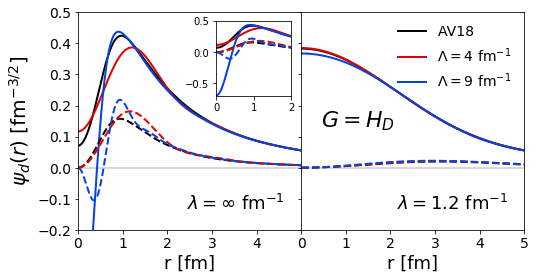

In [24]:
# # Deuteron coordinate-space wave functions for high cutoff potentials and AV18 with Wegner generator at 
# # \lambda = 1.2 fm^-1

# kvnns = (6, 900, 901)
# generator = 'Wegner'
# lamb = 1.2
# f, axs = deuteron_wave_func_coord_space(kvnns, generator, lamb)

# # Add legend for wave function components and SRG-evolution
# legend_size = 14
# legend_location = 'upper right'
# axs[1].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add \lambda label
# lambda_label_size = 18
# lambda_label_location = 'lower right'
# for i in range(2):
#     if i == 0:
#         lambda_label = r'$\lambda=\infty$' + ' fm' + r'$^{-1}$'
#     else:
#         lambda_label = r'$\lambda=%.1f$' % lamb + ' fm' + r'$^{-1}$'
#     anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size), 
#                                  frameon=False)
#     axs[i].add_artist(anchored_text)
    
# # Add generator label
# generator_label = ff.generator_label_conversion(generator)
# generator_label_size = 22
# generator_label_location = 'center left'
# anchored_text = AnchoredText(generator_label, loc=generator_label_location, prop=dict(size=generator_label_size), 
#                              frameon=False)
# axs[1].add_artist(anchored_text)

# # Set file name
# file_name = 'deuteron_wave_func_coord_space_kvnns'
# for kvnn in kvnns:
#     file_name += '_%d' % kvnn
# file_name += '_%s%.1f' % (generator, lamb)
# file_name = ff.replace_periods(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__Evolution of $a^{\dagger}_q a_q(k,k')$__

In [25]:
def momentum_projection_contours(q, kvnn, channel, generators, lambda_array, colorbar_limits=(-0.01, 0.01)):
    """
    Plots SRG-evolved momentum projection operators [fm^6] with respect to momentum [fm^-1]. This is an m x n 
    contour plot where m is the size of generators and n is the size of lambda_array.
    
    Parameters
    ----------
    q : float
        Momentum projection value [fm^-1].
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel (e.g. '1S0').
    generators : tuple
        SRG generators where each element is a string (e.g. ('Wegner', 'Block-diag')).
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    colorbar_limits : tuple, optional
        Tuple specifying the minimum and maximum values [fm^6] of the colorbar.

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """
    
    # --- Set-up --- #
    
    # Load momentum, weights, and initial Hamiltonian
    k_array, k_weights = vnn.load_momentum(kvnn, channel)
    # Length of k_array
    ntot = len(k_array)
    H_initial = vnn.load_hamiltonian(kvnn, channel)
    # Divide out these factors to present mesh-independent result
    factor_array = k_array * np.sqrt(k_weights) * np.sqrt(2/np.pi)
    row, col = np.meshgrid(factor_array, factor_array)
    
    # Size of figure
    row_number = len(generators)
    col_number = len(lambda_array)
    figure_size = (4*col_number, 3.5*row_number) # Extra width for colorbar

    # Axes limits
    axes_max = 4.0
    axes_lim = [0.0, axes_max]
        
    # Axes ticks, labels, and fontsizes
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    axes_stepsize = 1.0 # Step-size in labeling tick marks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    axes_ticks_strings = ff.convert_ticks_to_labels(axes_ticks)
    axes_tick_size = 18
    
    # Colorbar ticks, label, and fontsize
    mn = colorbar_limits[0]
    mx = colorbar_limits[1]
    levels_number = 61
    levels = np.linspace(mn, mx, levels_number)
    levels_ticks = np.linspace(mn, mx, 9)
    levels_ticks_strings = ff.convert_ticks_to_labels(levels_ticks)
    colorbar_label = '[fm' + r'$^6$' + ']'
    colorbar_label_size = 22
    colorbar_tick_size = 20
    
    # Color scheme for contour plots
    color_style = 'turbo'
        

    # --- Load operators --- #
    
    # Initialize dictionary to store evolved potentials
    d = {}
    
    # Loop over generators
    for generator in generators:
        
        # Store momentum and operator in here
        d[generator] = {}
        
        # Loop over lambda values
        for lamb in lambda_array:
            
            # Load unitary transformation
            # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
            if generator == 'Block-diag':
                H_evolved = vnn.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=1.0,
                                                 lambda_bd=lamb)
            else:
                H_evolved = vnn.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb)

            U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
            
            # Evolved momentum projection operator
            operator = op.momentum_projection_operator(q, k_array, k_weights, channel, U_matrix)
            # Take only the upper sub-block if coupled-channel 
            if vnn.coupled_channel(channel):
                operator = operator[:ntot, :ntot]
            # Divide by k_i * k_j * sqrt( w_i * w_j ) for mesh-independent result
            operator = operator / row / col
                
            # Interpolate the operator through 0 to axes_max for smoother looking figure (the extension _int means 
            # interpolated)
            k_array_int, operator_int = ff.interpolate_matrix(k_array, operator, axes_max+0.2)
            
            # Store in dictionary with generator and lamb as keys
            d[generator][lamb] = operator_int

        
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over generators and lambda's keeping track of indices
    for i, generator in enumerate(generators):
        for j, lamb in enumerate(lambda_array):
            
            c = axs[i, j].contourf(k_array_int, k_array_int, d[generator][lamb], levels, cmap=color_style, 
                                   extend='both')
                                         
            # Specify axes limits
            axs[i, j].set_xlim( axes_lim )
            axs[i, j].set_ylim( axes_lim )
                     
            # On the top row, set and label x-axis
            if i == 0:
                                         
                # Specify axes tick marks
                axs[i, j].xaxis.set_ticks(axes_ticks)
                axs[i, j].xaxis.set_ticklabels(axes_ticks_strings)
                # Switch from bottom to top
                axs[i, j].xaxis.set_label_position('top')
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=True, labelsize=axes_tick_size)
                                         
                # Prevent overlapping x-axis tick marks
                if j < col_number - 1:
                    xticks = axs[i, j].xaxis.get_major_ticks()
                    xticks[-1].set_visible(False)

                # Set x-axis label
                axs[i, j].set_xlabel(x_label, fontsize=axes_label_size)
                                         
            # On the left column, set and label y-axis
            if j == 0:
                                         
                # Specify axes tick marks
                axs[i, j].yaxis.set_ticks(axes_ticks)
                axs[i, j].yaxis.set_ticklabels(axes_ticks_strings)
                axs[i, j].tick_params(labelsize=axes_tick_size)
                                      
                # Prevent overlapping y-axis tick marks
                if i < row_number - 1:
                    yticks = axs[i, j].yaxis.get_major_ticks()
                    yticks[-1].set_visible(False)
                                         
                # Set y-axis label
                axs[i, j].set_ylabel(y_label, fontsize=axes_label_size)
                                         
            # On the bottom row, switch x-axis from bottom to top
            if i == row_number - 1:
                                         
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=False, labelsize=axes_tick_size)

    # Invert y-axis
    plt.gca().invert_yaxis()
                                         
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                                         
    # Set colorbar axe
    f.subplots_adjust(right=0.8) # Adjust for colorbar space
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    cbar.ax.set_yticklabels(levels_ticks_strings)
                                         
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

    return f, axs

In [26]:
# # Contours of evolved momentum projection operator under RKE N4LO 450 MeV transformations where q = 0.3 fm^-1

# q = 0.3
# kvnn = 111
# channel = '3S1'
# generators = ('Wegner', 'Block-diag')
# lambda_array = np.array([6.0, 3.0, 2.0, 1.5])
# colorbar_limits = (-0.1, 0.1)
# f, axs = momentum_projection_contours(q, kvnn, channel, generators, lambda_array, colorbar_limits)

# # Add generator label to each subplot on the 1st column
# generator_label_size = 17
# generator_label_location = 'center right'
# for i, generator in enumerate(generators):
#     generator_label = ff.generator_label_conversion(generator)
#     anchored_text = AnchoredText(generator_label, loc=generator_label_location, 
#                                  prop=dict(size=generator_label_size))
#     axs[i, 0].add_artist(anchored_text)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'lower right'
# for i, generator in enumerate(generators):
#     for j, lamb in enumerate(lambda_array):
#         lambda_label = ff.lambda_label_conversion(lamb, generator)
#         anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size))
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'momentum_projection_contours_q%.2f_kvnn_%d_%s' % (q, kvnn, channel)
# file_name = ff.replace_periods(file_name)
# file_name += '.png'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [27]:
# # Contours of evolved momentum projection operator under RKE N4LO 450 MeV transformations where q = 3.0 fm^-1

# q = 3.0
# kvnn = 111
# channel = '3S1'
# generators = ('Wegner', 'Block-diag')
# lambda_array = np.array([6.0, 3.0, 2.0, 1.5])
# f, axs = momentum_projection_contours(q, kvnn, channel, generators, lambda_array)

# # Add generator label to each subplot on the 1st column
# generator_label_size = 17
# generator_label_location = 'upper left'
# for i, generator in enumerate(generators):
#     generator_label = ff.generator_label_conversion(generator)
#     anchored_text = AnchoredText(generator_label, loc=generator_label_location, 
#                                  prop=dict(size=generator_label_size))
#     axs[i, 0].add_artist(anchored_text)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'lower left'
# for i, generator in enumerate(generators):
#     for j, lamb in enumerate(lambda_array):
#         lambda_label = ff.lambda_label_conversion(lamb, generator)
#         anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size))
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'momentum_projection_contours_q%.2f_kvnn_%d_%s' % (q, kvnn, channel)
# file_name = ff.replace_periods(file_name)
# file_name += '.png'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__Visualization of $r^2(k,k')$__

In [28]:
def r2_3d_plot(k_array, k_weights, r_array, dr, a=1000, zlim=(-3000, 3000)):
    """
    Plots the r^2 operator with integration factors k and k' [fm^3] with respect to momentum [fm^-1]. This is a 
    1 x 1 plot.
    
    Parameters
    ----------
    k_array : 1-D ndarray
        Momentum array [fm^-1].
    k_weights : 1-D ndarray
        Momentum weights [fm^-1].
    r_array : 1-D ndarray
        Coordinates array [fm].
    dr : float
        Coordinates step-size (weight) [fm].
    a : float, optional
        Parameter in regulator function. Gives an option to regulate the r^2 operator in momentum space with an 
        exponential function exp^[-r^2/a^2] where a = 5 fm. If a > 100 fm, we assume the exponential function is
        1 (and thus do not regulate the operator).
    xlim : tuple, optional
        Limits of z-axis [fm^3].

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # --- Set-up --- #
    
    # Divide out integration weights only
    factor_array = np.concatenate( (np.sqrt(k_weights), np.sqrt(k_weights)) )
    row, col = np.meshgrid(factor_array, factor_array)
    
    # Size of figure
    row_number = 1
    col_number = 2 # Set wider for better viewing angle (even though it's 1 x 1)
    figure_size = (4*col_number, 3.5*row_number)

    # Axes limits
    axes_max = 3.0
    axes_lim = [0.0, axes_max]
    
    # Axes ticks, labels, and fontsizes
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    z_ticks = np.linspace(zlim[0], zlim[1], 5)
    if a <= 6:
        z_tick_labels = [''] + [' %d' % z for z in z_ticks[1:]]
    elif a <= 10:
        z_tick_labels = [''] + [' %d' % z for z in z_ticks[1:]]
    else:
        z_tick_labels = [''] + ['    %d' % z for z in z_ticks[1:]]
    axes_label_size = 18
    axes_stepsize = 1.0 # Step-size in labeling tick marks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    axes_ticks_strings = ff.convert_ticks_to_labels(axes_ticks)
    axes_tick_size = 15
    
    # Number of contour levels
    levels_number = 601
    
    # Color scheme for contour plots
    color_style = 'turbo'
    
    
    # --- Load operators --- #
    
    r2_operator = op.r2_operator(k_array, k_weights, r_array, dr, a=a) / row / col

    # Interpolate the operator through 0 to axes_max for smoother looking figure (the extension _int means 
    # interpolated)
    k_array_int, r2_operator_int = ff.interpolate_matrix(k_array, r2_operator, axes_max+0.2)
    # Get k_array grids
    k_rows, k_cols = np.meshgrid(k_array_int, k_array_int)

    
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    ax = plt.axes(projection='3d')
    ax.plot_surface(k_rows, k_cols, r2_operator_int, vmin=zlim[0], vmax=zlim[1], cmap=color_style)
        
    # Specify axes limits
    ax.set_xlim( axes_lim )
    ax.set_ylim( axes_lim )
    ax.set_zlim( zlim )
                     
    # Specify axes tick marks
    ax.xaxis.set_ticks(axes_ticks)
    ax.xaxis.set_ticklabels(axes_ticks_strings)
    ax.yaxis.set_ticks(axes_ticks)
    ax.yaxis.set_ticklabels(axes_ticks_strings)
    ax.zaxis.set_ticks(z_ticks)
    ax.zaxis.set_ticklabels(z_tick_labels)
    ax.tick_params(labelsize=axes_tick_size)

    # Set axes label
    ax.set_xlabel('\n'+x_label, fontsize=axes_label_size, labelpad=15)
    ax.set_ylabel('\n'+y_label, fontsize=axes_label_size, labelpad=15)

    # Invert y-axis
    plt.gca().invert_yaxis()
    
    plt.tight_layout()

    return f, ax

In [29]:
# # Unregulated r^2 operator

# k_array, k_weights = vnn.load_momentum(111, '3S1') # Standard momentum array
# r_min = 0.005
# r_max = 30.2
# dr = 0.005
# r_array = np.arange(r_min, r_max + dr, dr)
# f, ax = r2_3d_plot(k_array, k_weights, r_array, dr, a=1000)

# # Adjust viewing angle
# ax.view_init(35, 120) # Rotate \theta and \phi 
# ax.dist = 12 # Manually zoom in/out to prevent axes labels from being cutoff

# # Set file name
# file_name = 'r2_3d_plot_unregulated.png'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# bbox = Bbox([[1.0, 0.0], [7.5, 3.5]])
# f.savefig(file_name, bbox_inches=bbox) # Cut out unnecessary white space
# chdir(cwd)

In [30]:
# # Regulated r^2 operator where a = 6 fm

# k_array, k_weights = vnn.load_momentum(111, '3S1') # Standard momentum array
# r_min = 0.005
# r_max = 30.2
# dr = 0.005
# r_array = np.arange(r_min, r_max + dr, dr)
# a = 6
# zlim = (-40, 40)
# f, ax = r2_3d_plot(k_array, k_weights, r_array, dr, a, zlim)

# # Adjust viewing angle
# ax.view_init(35, 120) # Rotate \theta and \phi 
# ax.dist = 12 # Manually zoom in/out to prevent axes labels from being cutoff

# # Set file name
# file_name = 'r2_3d_plot_regulated_a%d.png' % a

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# bbox = Bbox([[1.0, 0.0], [7.5, 3.5]])
# f.savefig(file_name, bbox_inches=bbox) # Cut out unnecessary white space
# chdir(cwd)

In [31]:
# # Regulated r^2 operator where a = 10 fm

# k_array, k_weights = vnn.load_momentum(111, '3S1') # Standard momentum array
# r_min = 0.005
# r_max = 30.2
# dr = 0.005
# r_array = np.arange(r_min, r_max + dr, dr)
# a = 10
# zlim = (-200, 200)
# f, ax = r2_3d_plot(k_array, k_weights, r_array, dr, a, zlim)

# # Adjust viewing angle
# ax.view_init(35, 120) # Rotate \theta and \phi 
# ax.dist = 12 # Manually zoom in/out to prevent axes labels from being cutoff

# # Set file name
# file_name = 'r2_3d_plot_regulated_a%d.png' % a

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# bbox = Bbox([[1.0, 0.0], [7.5, 3.5]])
# f.savefig(file_name, bbox_inches=bbox) # Cut out unnecessary white space
# chdir(cwd)

__Contributions to $<\psi_d|P O P|\psi_d>$__

In [32]:
def resize_coupled_channel_matrix(M, l, ntot, subblock='PP'):
    """
    Returns a resized coupled-channel matrix.
    
    Parameters
    ----------
    M : 2-D ndarray
        Coupled-channel matrix. Units are arbitrary.
    l : float
        Cutoff value. Units should match the units of which M depends on.
    ntot : int
        Length of each sub-block of the coupled-channel matrix. This implies that len(M) = 2*ntot.
    subblock : str, optional
        The truncated component to be returned where P and Q are projection operators split by the cutoff l.
        
    Returns
    -------
    M_resized : 2-D ndarray
        The resized coupled-channel matrix. Units match the units of M.
        
    """
    
    if subblock == 'PP': # Resize to PP sub-block
        M_resized = np.vstack( ( np.hstack( (M[:l, :l], M[:l, ntot:l+ntot]) ),
                                 np.hstack( (M[ntot:l+ntot, :l], M[ntot:l+ntot, ntot:l+ntot]) ) ) )
    elif subblock == 'PQ': # Resize to PQ sub-block
        M_resized = np.vstack( ( np.hstack( (M[:l, l:ntot], M[:l, l+ntot:]) ),
                                 np.hstack( (M[ntot:l+ntot, l:ntot], M[ntot:l+ntot, l+ntot:]) ) ) )
    elif subblock == 'QP': # Resize to QP sub-block
        M_resized = np.vstack( ( np.hstack( (M[l:ntot, :l], M[l:ntot, ntot:l+ntot]) ),
                                 np.hstack( (M[l+ntot:, :l], M[l+ntot:, ntot:l+ntot]) ) ) )
    else: # Resize to QQ sub-block
        M_resized = np.vstack( ( np.hstack( (M[l:ntot, l:ntot], M[l:ntot, l+ntot:]) ),
                                 np.hstack( (M[l+ntot:, l:ntot], M[l+ntot:, l+ntot:]) ) ) )
        
    return M_resized

In [33]:
def plot_r2_srg_changes(kvnn, generator, lamb, colorbar_limits=(-4, 4)):
    """
    Plots SRG contributions to Pr^2P [fm^5] with respect to momentum [fm^-1] splitting Pr^2P into four components.
    This is a 1 x 4 contour plot.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float
        Evolution parameter lambda [fm^-1].
    colorbar_limits : tuple, optional
        Tuple specifying the minimum and maximum values [fm^5] of the colorbar.
        
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """
    
    # --- Set-up --- #
    
    # Fix channel to 3S1-3D1 coupled-channel
    channel = '3S1'
    
    # Standard r_array
    r_min = 0.005
    r_max = 30.2
    dr = 0.005
    r_array = np.arange(r_min, r_max + dr, dr)

    # Size of figure
    row_number = 1
    col_number = 4
    figure_size = (4*col_number, 3.5*row_number) # Extra width for colorbar

    # Axes limits
    axes_max = 3.0
    axes_lim = [0.0, axes_max]
        
    # Axes ticks, labels, and fontsizes
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    axes_stepsize = 1.0 # Step-size in labeling tick marks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    axes_ticks_strings = ff.convert_ticks_to_labels(axes_ticks)
    axes_tick_size = 18
    
    # Colorbar ticks, label, and fontsize
    mn = colorbar_limits[0]
    mx = colorbar_limits[1]
    levels_number = 61
    levels = np.linspace(mn, mx, levels_number)
    levels_ticks = np.linspace(mn, mx, 9)
    levels_ticks_strings = ff.convert_ticks_to_labels(levels_ticks)
    colorbar_label = '[fm' + r'$^5$' + ']'
    colorbar_label_size = 22
    colorbar_tick_size = 20
    
    # Color scheme for contour plots
    color_style = 'turbo'
    
    
    # --- Load data --- #
    
    # Store r^2_PP contributions in dictionary with kvnns as keys
    d = {}
    
    # Load momentum/weights and initial Hamiltonian
    k_array, k_weights = vnn.load_momentum(kvnn, channel)
    ntot = len(k_array)
    H_initial = vnn.load_hamiltonian(kvnn, channel)
        
    # Index of lambda in k_array
    l = op.find_q_index(lamb, k_array)
    if k_array[l] < lamb: # Prevent undershooting \lambda
        l += 1
            
    # Truncate momentum array up to \lambda
    k_array_P = k_array[:l]
    k_weights_P = k_weights[:l]
    factor_array = np.concatenate( (np.sqrt( (2*k_weights_P) / np.pi ) * k_array_P, 
                                    np.sqrt( (2*k_weights_P) / np.pi ) * k_array_P) )
    row, col = np.meshgrid(factor_array, factor_array)
                                      
    # Initial operator (with momenta/weights)
    op_initial = op.r2_operator(k_array, k_weights, r_array, dr)
    # Split initial operator into four components
    op_initial_PP = resize_coupled_channel_matrix(op_initial, l, ntot, 'PP')
    op_initial_PQ = resize_coupled_channel_matrix(op_initial, l, ntot, 'PQ')
    op_initial_QP = resize_coupled_channel_matrix(op_initial, l, ntot, 'QP')
    op_initial_QQ = resize_coupled_channel_matrix(op_initial, l, ntot, 'QQ')
        
    # Load evolved Hamiltonian
    if generator == 'Block-diag':
        H_evolved = vnn.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=1.0,
                                         lambda_bd=lamb)
    else:
        H_evolved = vnn.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb)
            
    # Calculate SRG transformation (with momenta/weights)
    U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
            
    # Resize U_matrix (with momenta/weights)
    U_matrix_PP = resize_coupled_channel_matrix(U_matrix, l, ntot, 'PP')
    U_matrix_PQ = resize_coupled_channel_matrix(U_matrix, l, ntot, 'PQ')
            
    # Calculate r^2 in each sub-block (with momenta/weights)
    op_evolved_PP = U_matrix_PP @ op_initial_PP @ U_matrix_PP.T # P to P
    op_evolved_PQ = U_matrix_PP @ op_initial_PQ @ U_matrix_PQ.T # P to Q
    op_evolved_QP = U_matrix_PQ @ op_initial_QP @ U_matrix_PP.T # Q to P
    op_evolved_QQ = U_matrix_PQ @ op_initial_QQ @ U_matrix_PQ.T # Q to Q
            
    # Take difference in PP part
    delta_op_PP = op_evolved_PP - op_initial_PP
                                      
    # Resize the matrices up to axes_max fm^-1 for 3S1 only (they will be zero past \lambda) and divide out
    # integration factors
    delta_op_PP_full = np.zeros( (ntot, ntot) ) 
    delta_op_PP_full[:l, :l] = ( delta_op_PP / row / col )[:l, :l]
    op_evolved_PQ_full = np.zeros( (ntot, ntot) ) 
    op_evolved_PQ_full[:l, :l] = ( op_evolved_PQ / row / col )[:l, :l]
    op_evolved_QP_full = np.zeros( (ntot, ntot) ) 
    op_evolved_QP_full[:l, :l] = ( op_evolved_QP / row / col )[:l, :l]
    op_evolved_QQ_full = np.zeros( (ntot, ntot) ) 
    op_evolved_QQ_full[:l, :l] = ( op_evolved_QQ / row / col)[:l, :l]
                                       
    # Interpolate each
    k_array_int, delta_op_PP_int = ff.interpolate_matrix(k_array, delta_op_PP_full, axes_max+0.2)
    k_array_int, op_evolved_PQ_int = ff.interpolate_matrix(k_array, op_evolved_PQ_full, axes_max+0.2)
    k_array_int, op_evolved_QP_int = ff.interpolate_matrix(k_array, op_evolved_QP_full, axes_max+0.2)
    k_array_int, op_evolved_QQ_int = ff.interpolate_matrix(k_array, op_evolved_QQ_full, axes_max+0.2)
                                      
    # Store in dictionary
    d['PP'] = delta_op_PP_int
    d['PQ'] = op_evolved_PQ_int
    d['QP'] = op_evolved_QP_int
    d['QQ'] = op_evolved_QQ_int
            
            
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over sub-blocks keeping track of indices
    for i, subblock in enumerate( ['PP', 'PQ', 'QP', 'QQ'] ):

        c = axs[i].contourf(k_array_int, k_array_int, d[subblock], levels, cmap=color_style, extend='both')
                                         
        # Specify axes limits
        axs[i].set_xlim( axes_lim )
        axs[i].set_ylim( axes_lim )
                     
        # Specify axes tick marks
        axs[i].xaxis.set_ticks(axes_ticks)
        axs[i].xaxis.set_ticklabels(axes_ticks_strings)
        # Switch from bottom to top
        axs[i].xaxis.set_label_position('top')
        axs[i].xaxis.tick_top()
        axs[i].tick_params(labeltop=True, labelsize=axes_tick_size)
                                         
        # Prevent overlapping x-axis tick marks
        if i < col_number - 1:
            xticks = axs[i].xaxis.get_major_ticks()
            xticks[-1].set_visible(False)

        # Set x-axis label
        axs[i].set_xlabel(x_label, fontsize=axes_label_size)
                                         
        # On the left column, set and label y-axis
        if i == 0:
                                         
            # Specify axes tick marks
            axs[i].yaxis.set_ticks(axes_ticks)
            axs[i].yaxis.set_ticklabels(axes_ticks_strings)
            axs[i].tick_params(labelsize=axes_tick_size)
                
            # Set y-axis label
            axs[i].set_ylabel(y_label, fontsize=axes_label_size)

    # Invert y-axis
    plt.gca().invert_yaxis()
    
    # Set colorbar axe
    f.subplots_adjust(right=0.8) # Adjust for colorbar space
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    cbar.ax.set_yticklabels(levels_ticks_strings)
                                         
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)
                                         
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)

    return f, axs

In [34]:
# # Contributions to \delta r^2_PP splitting the evolved operator into 4 parts with block-diagonal evolution from 
# # RKE N4LO 450 MeV

# kvnn = 111
# generator = 'Block-diag'
# lamb = 2.0
# f, axs = plot_r2_srg_changes(kvnn, generator, lamb)

# # Add sub-block label to each sub-plot
# subblocks = ['P-P', 'P-Q', 'Q-P', 'Q-Q']
# subblock_size = 20
# subblock_location = 'lower right'
# for i, subblock in enumerate(subblocks):
#     anchored_text = AnchoredText(subblock, loc=subblock_location, prop=dict(size=subblock_size))
#     axs[i].add_artist(anchored_text)

# # Set file name
# file_name = 'r2_srg_changes_kvnn_%d_%s' % (kvnn, generator)
# file_name += '.png'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [35]:
# # Contributions to \delta r^2_PP splitting the evolved operator into 4 parts with band-diagonal evolution from 
# # RKE N4LO 450 MeV

# kvnn = 111
# generator = 'Wegner'
# lamb = 2.0
# f, axs = plot_r2_srg_changes(kvnn, generator, lamb)

# # Add sub-block label to each sub-plot
# subblocks = ['P-P', 'P-Q', 'Q-P', 'Q-Q']
# subblock_size = 20
# subblock_location = 'lower right'
# for i, subblock in enumerate(subblocks):
#     anchored_text = AnchoredText(subblock, loc=subblock_location, prop=dict(size=subblock_size))
#     axs[i].add_artist(anchored_text)

# # Set file name
# file_name = 'r2_srg_changes_kvnn_%d_%s' % (kvnn, generator)
# file_name += '.png'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [36]:
# # Contributions to \delta r^2_PP splitting the evolved operator into 4 parts with block-diagonal evolution from 
# # AV18

# kvnn = 6
# generator = 'Block-diag'
# lamb = 2.0
# f, axs = plot_r2_srg_changes(kvnn, generator, lamb)

# # Add sub-block label to each sub-plot
# subblocks = ['P-P', 'P-Q', 'Q-P', 'Q-Q']
# subblock_size = 20
# subblock_location = 'lower right'
# for i, subblock in enumerate(subblocks):
#     anchored_text = AnchoredText(subblock, loc=subblock_location, prop=dict(size=subblock_size))
#     axs[i].add_artist(anchored_text)

# # Set file name
# file_name = 'r2_srg_changes_kvnn_%d_%s' % (kvnn, generator)
# file_name += '.png'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [37]:
def quantify_srg_changes(kvnns, generator, lamb, operator='r2'):
    """
    Calculates SRG contributions to <\psi_d|POP|\psi_d> [fm^5] with respect to momentum [fm^-1] splitting POP into
    four components where O is some operator and \psi_d is the deuteron wave function.
    
    Parameters
    ----------
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float
        Evolution parameter lambda [fm^-1].
    operator : str, optional
        The operator to analyze (e.g. 'r2').
        
    Returns
    -------
    d : dict
        Dictionary storing the contributions to POP for each potential.
        
    """
    
    # --- Set-up --- #
    
    # Channel is 3S1-3D1 for deuteron
    channel = '3S1'
    
    # Parameters for different operators
    if operator == 'r2':
        # Specify r_array
        r_min = 0.005
        r_max = 30.2
        dr = 0.005
        r_array = np.arange(r_min, r_max + dr, dr)
    elif operator == 'ataq':
        # Specify q value
        q = 3.0
    
    
    # --- Calculate r_d values --- #
    
    # Store contributions in dictionary with kvnns and sub-blocks as keys
    d = {}
    
    # Loop over kvnns
    for kvnn in kvnns:
        
        d[kvnn] = {}
        
        # Set momentum mesh specifications
        kmax = 10.0
        # Note, AV18 requires kmid = 3 fm^-1
        if kvnn == 6:
            kmid = 3.0
        else:
            kmid = 2.0
        ntot = 120
        
        # Load momentum/weights, initial and evolved Hamiltonians
        k_array, k_weights = vnn.load_momentum(kvnn, channel, kmax, kmid, ntot)
        H_initial = vnn.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
        if generator == 'Block-diag':
            H_evolved = vnn.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, method='srg', generator=generator,
                                             lamb=1.0, lambda_bd=lamb)
        else:
            H_evolved = vnn.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, method='srg', generator=generator,
                                             lamb=lamb)
            
        # Calculate SRG transformation (unitless)
        U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
        # Load wave functions (unitless)
        psi_initial = ob.wave_function(H_initial)
        psi_evolved = ob.wave_function(H_initial, U=U_matrix)
        
        # Index of lambda in k_array
        l = op.find_q_index(lamb, k_array)
        if k_array[l] < lamb: # Prevent undershooting \lambda
            l += 1
        
        # Initial operator
        if operator == 'r2':
            # Units of r^2 are fm^2
            op_initial = op.r2_operator(k_array, k_weights, r_array, dr) # Full operator
            op_initial_PP = resize_coupled_channel_matrix(op_initial, l, ntot, 'PP') # P-P sub-block
            op_initial_PQ = resize_coupled_channel_matrix(op_initial, l, ntot, 'PQ') # P-Q sub-block
            op_initial_QP = resize_coupled_channel_matrix(op_initial, l, ntot, 'QP') # Q-P sub-block
            op_initial_QQ = resize_coupled_channel_matrix(op_initial, l, ntot, 'QQ') # Q-Q sub-block
        elif operator == 'ataq':
            # Units of \ataq are fm^3
            op_initial = op.momentum_projection_operator(q, k_array, k_weights, channel) # Full operator
            op_initial_PP = resize_coupled_channel_matrix(op_initial, l, ntot, 'PP') # P-P sub-block
            op_initial_PQ = resize_coupled_channel_matrix(op_initial, l, ntot, 'PQ') # P-Q sub-block
            op_initial_QP = resize_coupled_channel_matrix(op_initial, l, ntot, 'QP') # Q-P sub-block
            op_initial_QQ = resize_coupled_channel_matrix(op_initial, l, ntot, 'QQ') # Q-Q sub-block
            
        # Resize evolved wave function to P elements only
        psi_evolved_P = np.concatenate( (psi_evolved[:l], psi_evolved[ntot:l+ntot]) )
            
        # Resize U_matrix (with momenta/weights)
        U_matrix_PP = resize_coupled_channel_matrix(U_matrix, l, ntot, 'PP')
        U_matrix_PQ = resize_coupled_channel_matrix(U_matrix, l, ntot, 'PQ')
            
        # Calculate evolved operator in each sub-block (with momenta/weights)
        op_evolved_PP = U_matrix_PP @ op_initial_PP @ U_matrix_PP.T # P to P
        op_evolved_PQ = U_matrix_PP @ op_initial_PQ @ U_matrix_PQ.T # P to Q
        op_evolved_QP = U_matrix_PQ @ op_initial_QP @ U_matrix_PP.T # Q to P
        op_evolved_QQ = U_matrix_PQ @ op_initial_QQ @ U_matrix_PQ.T # Q to Q
            
        # Take difference in PP part
        delta_op_PP = op_evolved_PP - op_initial_PP
           
        # Store in dictionary (units are fm^2)
        d[kvnn]['PP'] = psi_evolved_P.T @ delta_op_PP @ psi_evolved_P
        d[kvnn]['PQ'] = psi_evolved_P.T @ op_evolved_PQ @ psi_evolved_P
        d[kvnn]['QP'] = psi_evolved_P.T @ op_evolved_QP @ psi_evolved_P
        d[kvnn]['QQ'] = psi_evolved_P.T @ op_evolved_QQ @ psi_evolved_P

    return d

In [38]:
# # Quantify block-diagonal SRG induced changes in r^2_PP

# kvnns = (6, 111)
# generator = 'Block-diag'
# lamb = 2.0

# d = quantify_srg_changes(kvnns, generator, 2.0, operator='r2')

# # Print results
# print('-'*80)
# print("<\psi|r^2_PP|\psi> measuring different contributions from U(k,k') in P and Q:")
# print('-'*80)
# for kvnn in kvnns:
#     print('kvnn = %d' % kvnn)
#     print('')
#     print('PP=%.4e, PQ+QP=%.4e, QQ=%.4e' % (d[kvnn]['PP'], d[kvnn]['PQ'] + d[kvnn]['QP'], d[kvnn]['QQ']))
#     print('')

In [39]:
# # Quantify block-diagonal SRG induced changes in \ataq^2_PP

# kvnns = (6, 111)
# generator = 'Block-diag'
# lamb = 2.0

# d = quantify_srg_changes(kvnns, generator, 2.0, operator='ataq')

# # Print results
# print('-'*80)
# print("<\psi|[a^{\dagger}_q a_q]_PP|\psi> measuring different contributions from U(k,k') in P and Q:")
# print('-'*80)
# for kvnn in kvnns:
#     print('kvnn = %d' % kvnn)
#     print('')
#     print('PP=%.4e, PQ+QP=%.4e, QQ=%.4e' % (d[kvnn]['PP'], d[kvnn]['PQ'] + d[kvnn]['QP'], d[kvnn]['QQ']))
#     print('')

In [40]:
# # Quantify band-diagonal SRG induced changes in r^2_PP

# kvnns = (6, 111)
# generator = 'Wegner'
# lamb = 2.0

# d = quantify_srg_changes(kvnns, generator, 2.0, operator='r2')

# # Print results
# print('-'*80)
# print("<\psi|r^2_PP|\psi> measuring different contributions from U(k,k') in P and Q:")
# print('-'*80)
# for kvnn in kvnns:
#     print('kvnn = %d' % kvnn)
#     print('')
#     print('PP=%.4e, PQ+QP=%.4e, QQ=%.4e' % (d[kvnn]['PP'], d[kvnn]['PQ'] + d[kvnn]['QP'], d[kvnn]['QQ']))
#     print('')

__Evolution of $\psi^2(k)$__

In [41]:
def deuteron_momentum_distribution(kvnn, *generators):
    """
    Plots the deuteron momentum distribution [fm^3] with respect to momentum [fm^-1] for the initial distribution
    and different SRG-evolved distributions. This is a 1 x 1 semi-log plot.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    *generators : tuple
        Specifications for SRG-evolution in the format (generator, lambda, lambda_bd) where generator (str) is the
        SRG generator, lambda (float) is evolution parameter [fm^-1], and lambda_bd (float, optional) is the 
        block-diagonal cutoff [fm^-1].

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # Check that at least one generator was provided
    if not generators: 
        print('At least one generator must be specified.')
        return None
    
     
    # --- Set-up --- #
    
    # Channel is 3S1 for deuteron
    channel = '3S1'
    # Deuteron energy in MeV
    eps = -2.22
    
    # Load momentum, weights, and initial Hamiltonian
    k_array, k_weights = vnn.load_momentum(kvnn, channel)
    # Number of points in momentum array
    ntot = len(k_array)
    # Use factor_array to divide out momenta/weights for mesh-independent result
    factor_array = np.concatenate( (np.sqrt(k_weights) * k_array, np.sqrt(k_weights) * k_array) ) * np.sqrt(2/np.pi)
    
    # Load initial Hamiltonian
    H_initial = vnn.load_hamiltonian(kvnn, channel)
     
    # Compute initial wave function in units fm^3
    psi_initial = ob.wave_function(H_initial, eps) / factor_array
    u_initial = psi_initial[:ntot] # 3S1 component
    w_initial = psi_initial[ntot:] # 3D1 component
    
    # Initial momentum distribution
    psi_squared_initial = u_initial**2 + w_initial**2
    
    # Figure size
    width = 4
    height = 4
    figure_size = (width, height)
    
    # Axes limits
    xlim = [0.0, 4.0]
    ylim = [1e-5, 1e3]
        
    # Axes labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$\psi_d^2$' + ' [fm' + r'$^3$' + ']'
    y_label_size = 20
    axes_tick_size = 14
    
    # Curve width
    curve_width = 2.0
    
    
    # --- Calculate momentum distributions --- #
    
    # Initialize dictionary
    d = {}
    
    # Loop over SRG specifications
    for gen in generators:
        
        generator = gen[0] # SRG generator
        lamb = gen[1] # lambda value
        if generator == 'Block-diag':
            lambda_bd = gen[2] # Lambda_BD for block-diagonal evolution
        else:
            # Band-diagonal evolution -> set lambda_bd to 0
            lambda_bd = 0.0

        # Load unitary transformation
        # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
        H_evolved = vnn.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb,
                                         lambda_bd=lambda_bd)
        U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
        # Compute evolved wave function in units fm^3
        psi_evolved = ob.wave_function(H_initial, eps, U=U_matrix) / factor_array
        u_evolved = psi_evolved[:ntot] # 3S1 component
        w_evolved = psi_evolved[ntot:] # 3D1 component
        
        # Evolved momentum distribution
        psi_squared_evolved = u_evolved**2 + w_evolved**2
            
        # Store in dictionary with gen as key
        d[gen] = psi_squared_evolved
            
            
    # --- Plot data --- #
            
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size) 
    
    # Loop over kvnns and keep track of kvnns index
    for i, gen in enumerate(generators):
        
        generator = gen[0] # SRG generator
        lamb = gen[1] # lambda value
        if generator == 'Block-diag':
            lambda_bd = gen[2] # Lambda_BD for block-diagonal evolution
        else:
            # Band-diagonal evolution -> set lambda_bd to 0
            lambda_bd = 0.0
        
        # Curve color, styles, and labels
        curve_color = ff.xkcd_colors(i+1) # Color starting at red (initial momentum distribution will be black)
        if generator == 'Block-diag':
            lambda_bd = gen[2] # Lambda_BD for block-diagonal evolution
            curve_style = ff.line_styles(1) # Dash-dotted line style for block-diagonal
            curve_label = ff.lambda_label_conversion(lambda_bd, generator)
        else:
            curve_style = ff.line_styles(0) # Solid line style for band-diagonal
            curve_label = ff.lambda_label_conversion(lamb, generator)
        
        
        # Add curve to figure
        ax.semilogy(k_array, d[gen], color=curve_color, label=curve_label, linestyle=curve_style,
                    linewidth=curve_width)
        
    # Plot initial momentum distribution last to prevent it from being covered up
    curve_color = ff.xkcd_colors(0) # Initial momentum distribution is black
    curve_style = ff.line_styles(3) # Dotted line style
    curve_label = ff.lambda_label_conversion(np.inf) # Legend label
    
    # Add curve to figure
    ax.semilogy(k_array, psi_squared_initial, color=curve_color, label=curve_label, linestyle=curve_style,
                linewidth=curve_width)
    
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    
    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    
    return f, ax

In [42]:
# # Deuteron momentum distributions with RKE N4LO 450 MeV for band- and block-diagonal SRG evolution

# kvnn = 111
# # SRG generators and lambda values - (generator, lambda, lambda_bd)
# wegner_1_5 = ('Wegner', 1.5)
# block_diag_2 = ('Block-diag', 1.5, 2.00)
# block_diag_3 = ('Block-diag', 1.5, 3.00)
# f, ax = deuteron_momentum_distribution(kvnn, wegner_1_5, block_diag_2, block_diag_3)

# # Add legend for kvnns
# legend_size = 14
# legend_location = 'upper right'
# ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Set file name
# file_name = 'deuteron_momentum_distributions_kvnn_%d.pdf' % kvnn 

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [43]:
def high_energy_state_momentum_distribution(eps, kvnn, channel, *generators):
    """
    Plots a high-energy state momentum distribution [fm^3] with respect to momentum [fm^-1] for the initial 
    distribution and different SRG-evolved distributions. This is a 1 x 1 semi-log plot.
    
    Parameters
    ----------
    eps : float
        Eigenenergy of the state [MeV].
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel (e.g. '1S0').
    *generators : tuple
        Specifications for SRG-evolution in the format (generator, lambda, lambda_bd) where generator (str) is the
        SRG generator, lambda (float) is evolution parameter [fm^-1], and lambda_bd (float, optional) is the 
        block-diagonal cutoff [fm^-1].

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # Check that at least one generator was provided
    if not generators: 
        print('At least one generator must be specified.')
        return None
    
     
    # --- Set-up --- #
    
    # Coupled-channel (boolean variable) 
    coupled_channel = vnn.coupled_channel(channel)
    
    # Load momentum, weights, and initial Hamiltonian
    k_array, k_weights = vnn.load_momentum(kvnn, channel)
    # Number of points in momentum array
    ntot = len(k_array)
    # Use factor_array to divide out momenta/weights for mesh-independent result
    if coupled_channel:
        factor_array = np.concatenate( (np.sqrt(k_weights) * k_array, np.sqrt(k_weights) * k_array) ) * \
                       np.sqrt(2/np.pi)
    else:
        factor_array = np.sqrt( (2 * k_weights) / np.pi ) * k_array
        
    # Load initial Hamiltonian
    H_initial = vnn.load_hamiltonian(kvnn, channel)
     
    # Compute initial wave function in units fm^3
    psi_initial = ob.wave_function(H_initial, eps) / factor_array
    
    # Initial momentum distribution
    if coupled_channel:
        u_initial = psi_initial[:ntot]
        w_initial = psi_initial[ntot:]
        psi_squared_initial = u_initial**2 + w_initial**2
    else:
        psi_squared_initial = psi_initial**2
    
    # Figure size
    width = 4
    height = 4
    figure_size = (width, height)
    
    # Axes limiits
    xlim = [0.0, 5.0]
    ylim = [1e-6, 1e1]
    
    # Labels and fontsize
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$\psi_{\epsilon}^2$' + ' [fm' + r'$^3$' + ']'
    y_label_size = 20
    axes_tick_size = 14
    
    # Curve width
    curve_width = 2.0
    
    
    # --- Calculate momentum distributions --- #
    
    # Initialize dictionary
    d = {}
    
    # Loop over SRG specifications
    for gen in generators:
        
        generator = gen[0] # SRG generator
        lamb = gen[1] # lambda value
        if generator == 'Block-diag':
            lambda_bd = gen[2] # Lambda_BD for block-diagonal evolution
        else:
            # Band-diagonal evolution -> set lambda_bd to 0
            lambda_bd = 0.0

        # Load unitary transformation
        # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
        H_evolved = vnn.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb,
                                         lambda_bd=lambda_bd)
        U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
        # Compute evolved wave function and evolved momentum distributions
        psi_evolved = ob.wave_function(H_initial, eps, U=U_matrix) / factor_array
        
        # Evolved momentum distribution
        if coupled_channel:
            u_evolved = psi_evolved[:ntot]
            w_evolved = psi_evolved[ntot:]
            psi_squared_evolved = u_evolved**2 + w_evolved**2
        else:
            psi_squared_evolved = psi_evolved**2
        
        # Store in dictionary with gen as key
        d[gen] = psi_squared_evolved
            
            
    # --- Plot data --- #
            
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size) 
    
    # Loop over kvnns and keep track of kvnns index
    for i, gen in enumerate(generators):
        
        generator = gen[0] # SRG generator
        lamb = gen[1] # lambda value
        if generator == 'Block-diag':
            lambda_bd = gen[2] # Lambda_BD for block-diagonal evolution
        else:
            # Band-diagonal evolution -> set lambda_bd to 0
            lambda_bd = 0.0
        
        # Curve color, styles, and labels
        curve_color = ff.xkcd_colors(i+1) # Color starting at red (initial momentum distribution will be black)
        if generator == 'Block-diag':
            curve_style = ff.line_styles(1) # Dash-dotted line style for block-diagonal
            curve_label = ff.lambda_label_conversion(lambda_bd, generator)
        else:
            curve_style = ff.line_styles(0) # Solid line style for band-diagonal
            curve_label = ff.lambda_label_conversion(lamb, generator)
        
        # Add curve to figure
        ax.semilogy(k_array, d[gen], color=curve_color, label=curve_label, linestyle=curve_style,
                    linewidth=curve_width)
        
    # Plot initial momentum distribution last to prevent it from being covered up
    curve_color = ff.xkcd_colors(0) # Initial momentum distribution is black
    curve_style = ff.line_styles(3) # Dotted line style
    curve_label = ff.lambda_label_conversion(np.inf) # Legend label
    
    # Add curve to figure
    ax.semilogy(k_array, psi_squared_initial, color=curve_color, label=curve_label, linestyle=curve_style,
                linewidth=curve_width)
    
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    
    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    
    return f, ax

In [44]:
# # High-energy state (300 MeV) momentum distributions with RKE N4LO (450 MeV) and band- and block-diagonal SRG
# # evolution

# eps = 300.0
# kvnn = 111
# channel = '3S1'
# # SRG generators and lambda values - (generator, lambda, lambda_bd)
# wegner_1_5 = ('Wegner', 1.5)
# block_diag_2 = ('Block-diag', 1.5, 2.00)
# block_diag_3 = ('Block-diag', 1.5, 3.00)
# f, ax = high_energy_state_momentum_distribution(eps, kvnn, channel, wegner_1_5, block_diag_2, block_diag_3)

# # Set file name
# file_name = 'high_energy_state_eps%.1f_momentum_distributions_kvnn_%d' % (eps, kvnn)
# file_name = ff.replace_periods(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [45]:
# # Spurious state momentum distributions with \Lambda=9 fm^-1 and band- and block-diagonal SRG evolution

# eps = -2000
# kvnn = 901
# channel = '3S1'
# # SRG generators and lambda values - (generator, lambda, lambda_bd)
# wegner_1_2 = ('Wegner', 1.2)
# block_diag_2_0 = ('Block-diag', 1.2, 2.00)
# block_diag_2_8 = ('Block-diag', 1.2, 2.80)
# f, ax = high_energy_state_momentum_distribution(eps, kvnn, channel, wegner_1_2, block_diag_2_0, block_diag_2_8)

# # Add legend for kvnns
# legend_size = 14
# legend_location = 'upper left'
# ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0., fontsize=legend_size)
# # Set file name
# file_name = 'spurious_state_momentum_distributions_kvnn_%d' % kvnn
# file_name = ff.replace_periods(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__Integrand of $<\psi|a^{\dagger}_q a_q|\psi>$__

In [46]:
def momentum_projection_integrand_contours(q, kvnn, generators, lambda_array, eps=-2.22, colorbar_limits=(-8, -3)):
    """
    Plots SRG-evolved matrix elements of the momentum projection operator with some wave function [fm^5] with 
    respect to momentum [fm^-1]. This is an m x n contour plot where m is the size of generators and n is the 
    size of lambda_array.
    
    Parameters
    ----------
    q : float
        Momentum projection value [fm^-1].
    kvnn : int
        This number specifies the potential.
    generators : tuple
        SRG generators where each element is a string (e.g. ('Wegner', 'Block-diag')).
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    eps : float, optional
        Energy value of the state [MeV]. Default is the deuteron (eps = -2.22 MeV).
    colorbar_limits : tuple, optional
        Tuple specifying the minimum and maximum power of the log-scaled colorbar (e.g. (-8, -3) means the colorbar
        spans 10^-8 to 10^-3).

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """
    
    # --- Set-up --- #
    
    # Partial wave channel (fixing this to 3S1-3D1 for now)
    channel = '3S1'
    
    # Load momentum, weights, and initial Hamiltonian
    k_array, k_weights = vnn.load_momentum(kvnn, channel)
    # Length of k_array
    ntot = len(k_array)
    H_initial = vnn.load_hamiltonian(kvnn, channel)
    # Divide out these factors to present mesh-independent result (need to double the size for coupled-channel)
    # Note, keeping the factor of 2/\pi * k^2 * k'^2
    factor_array = np.concatenate( (np.sqrt(k_weights), np.sqrt(k_weights)) )
    row, col = np.meshgrid(factor_array, factor_array)
    
    # Size of figure
    row_number = len(generators)
    col_number = len(lambda_array)
    figure_size = (4*col_number, 3.5*row_number) # Extra width for colorbar

    # Axes limits
    axes_max = 4.0
    axes_lim = (0.0, axes_max)
        
    # Axes ticks, labels, and fontsizes
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    axes_stepsize = 1.0 # Step-size in labeling tick marks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    axes_ticks_strings = ff.convert_ticks_to_labels(axes_ticks)
    axes_tick_size = 18
        
    # Colorbar ticks, label, and fontsize
    mn = colorbar_limits[0]
    mx = colorbar_limits[1]
    levels_number = 61
    levels = np.logspace(mn, mx, levels_number)
    levels_ticks = np.logspace(mn, mx, mx-mn+1)
    levels_ticks_strings = [r'$10^{%d}$' % step for step in range(mn, mx+1)]
    colorbar_label = '[fm' + r'$^5$' + ']'
    colorbar_label_size = 22
    colorbar_tick_size = 20
    
    # Color scheme for contour plots
    color_style = 'Blues'
        

    # --- Load operators --- #
    
    # Initialize dictionary to store evolved potentials
    d = {}
    
    # Loop over generators
    for generator in generators:
        
        # Store momentum and operator in here
        d[generator] = {}
        
        # Loop over lambda values
        for lamb in lambda_array:
            
            # Load unitary transformation
            # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
            if generator == 'Block-diag':
                H_evolved = vnn.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=1.0,
                                                 lambda_bd=lamb)
            else:
                H_evolved = vnn.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb)
                
            U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
            
            # Evolved momentum projection operator
            operator = op.momentum_projection_operator(q, k_array, k_weights, channel, U_matrix)
            # Divide by sqrt( w_i * w_j ) for mesh-independent result
            operator = operator / row / col
            
            # Load evolved wave functions and divide out weights
            psi = ob.wave_function(H_initial, eps, U=U_matrix) / factor_array
            # Mesh-grids of psi
            psi_row, psi_col = np.meshgrid(psi, psi)
        
            # Matrix elements of < psi | a^dagger_q a_q | psi >
            integrand = psi_row * operator * psi_col
            
            # Re-size to upper sub-block block for coupled-channel
            integrand = integrand[:ntot, :ntot]
            
            # For log plot take absolute value
            integrand = abs(integrand)
            
            # Interpolate the integrand through 0 to axes_max for smoother looking figure (the extension _int means 
            # interpolated)
            k_array_int, integrand_int = ff.interpolate_matrix(k_array, integrand, axes_max+0.2)

            # Store in dictionary with generator and lamb as keys
            d[generator][lamb] = integrand_int
    
    
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over generators and lambda's keeping track of indices
    for i, generator in enumerate(generators):
        for j, lamb in enumerate(lambda_array):
            
            c = axs[i, j].contourf(k_array_int, k_array_int, d[generator][lamb], levels, 
                                       norm=colors.LogNorm(), cmap=color_style, extend='both')
                
            # Specify axes limits
            axs[i, j].set_xlim( axes_lim )
            axs[i, j].set_ylim( axes_lim )
                     
            # On the top row, set and label x-axis
            if i == 0:
                                         
                # Specify axes tick marks
                axs[i, j].xaxis.set_ticks(axes_ticks)
                axs[i, j].xaxis.set_ticklabels(axes_ticks_strings)
                # Switch from bottom to top
                axs[i, j].xaxis.set_label_position('top')
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=True, labelsize=axes_tick_size)
                                         
                # Prevent overlapping x-axis tick marks
                if j < col_number - 1:
                    xticks = axs[i, j].xaxis.get_major_ticks()
                    xticks[-1].set_visible(False)

                # Set x-axis label
                axs[i, j].set_xlabel(x_label, fontsize=axes_label_size)
                                         
            # On the left column, set and label y-axis
            if j == 0:
                                         
                # Specify axes tick marks
                axs[i, j].yaxis.set_ticks(axes_ticks)
                axs[i, j].yaxis.set_ticklabels(axes_ticks_strings)
                axs[i, j].tick_params(labelsize=axes_tick_size)
                                      
                # Prevent overlapping y-axis tick marks
                if i < row_number - 1:
                    yticks = axs[i, j].yaxis.get_major_ticks()
                    yticks[-1].set_visible(False)
                                         
                # Set y-axis label
                axs[i, j].set_ylabel(y_label, fontsize=axes_label_size)
                                         
            # On the bottom row, switch x-axis from bottom to top
            if i == row_number - 1:
                                         
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=False, labelsize=axes_tick_size)

    # Invert y-axis
    plt.gca().invert_yaxis()
                                         
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                                         
    # Set colorbar axe
    f.subplots_adjust(right=0.8) # Adjust for colorbar space
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    cbar.ax.set_yticklabels(levels_ticks_strings)
                                         
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

    return f, axs

In [47]:
# # Contours of matrix elements of the momentum projection operator with the deuteron wave function under RKE N4LO 
# # 450 MeV transformations where q = 3 fm^-1

# q = 3.0
# kvnn = 111
# generators = ('Wegner', 'Block-diag')
# lambda_array = np.array( (6.0, 3.0, 2.0, 1.5) )
# f, axs = momentum_projection_integrand_contours(q, kvnn, generators, lambda_array)

# # Add generator label to each subplot on the 1st column
# generator_label_size = 17
# generator_label_location = 'center left'
# for i, generator in enumerate(generators):
#     generator_label = ff.generator_label_conversion(generator)
#     anchored_text = AnchoredText(generator_label, loc=generator_label_location,
#                                  prop=dict(size=generator_label_size))
#     axs[i, 0].add_artist(anchored_text)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'lower left'
# for i, generator in enumerate(generators):
#     for j, lamb in enumerate(lambda_array):
#         lambda_label = ff.lambda_label_conversion(lamb, generator)
#         anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size))
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'momentum_projection_integrand_contours_q%.2f_kvnn_%d' % (q, kvnn)
# file_name = ff.replace_periods(file_name)
# file_name += '.png'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [48]:
# # Contours of matrix elements of the momentum projection operator with a high-energy state wave function under
# # RKE N4LO 450 MeV transformations where q = 3 fm^-1

# q = 3.0
# kvnn = 111
# generators = ('Wegner', 'Block-diag')
# lambda_array = np.array( (6.0, 3.0, 2.0, 1.5) )
# eps = 300.0
# f, axs = momentum_projection_integrand_contours(q, kvnn, generators, lambda_array, eps)

# # Add generator label to each subplot on the 1st column
# generator_label_size = 17
# generator_label_location = 'center left'
# for i, generator in enumerate(generators):
#     generator_label = ff.generator_label_conversion(generator)
#     anchored_text = AnchoredText(generator_label, loc=generator_label_location,
#                                  prop=dict(size=generator_label_size))
#     axs[i, 0].add_artist(anchored_text)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'upper left'
# for i, generator in enumerate(generators):
#     for j, lamb in enumerate(lambda_array):
#         lambda_label = ff.lambda_label_conversion(lamb, generator)
#         anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size))
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'momentum_projection_integrand_contours_q%.2f_kvnn_%d_eps_%.1f' % (q, kvnn, eps)
# file_name = ff.replace_periods(file_name)
# file_name += '.png'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__Convergence of $r_d$__

In [49]:
def r_d_relative_error(kvnns, generator, lamb):
    """
    Plots the relative error of the deuteron radius with respect to a momentum-space cutoff [fm^-1] for initial
    and SRG-evolved wave functions and operators. This is a 1 x 1 semi-log plot.
    
    Parameters
    ----------
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float
        Evolution parameter lambda [fm^-1].

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # --- Set-up --- #
    
    # Channel is 3S1-3D1 for deuteron
    channel = '3S1'
    
    # Specify r_array
    r_min = 0.005
    r_max = 30.2
    dr = 0.005
    r_array = np.arange(r_min, r_max + dr, dr)
    
    # Specify k_max values shifting more points to the low-k region
    k_max_values = np.concatenate( ( np.arange(0.4, 2.0, 0.2), np.arange(2.0, 10.5, 0.5) ) )
    m = len(k_max_values)
    
    # Figure size
    width = 4
    height = 4
    figure_size = (width, height)
    
    # Axes limits
    xlim = (0.0, 6.0)
    ylim = (1e-4, 1e0)
        
    # Axes labels and fontsize
    x_label = r'$k_{\rm max}$' + ' [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = r'$\epsilon_r$'
    y_label_size = 20
    axes_tick_size = 14
    
    # Curve width
    curve_width = 2.0
    
    
    # --- Calculate r_d values --- #
    
    # Store r_d in dictionary with kvnn and k_max keys
    d = {}
    
    # Loop over kvnns
    for kvnn in kvnns:
        
        d[kvnn] = {}
        
        # Set momentum mesh specifications
        kmax = 10.0
        # Note, AV18 requires kmid = 3 fm^-1
        if kvnn == 6:
            kmid = 3.0
        else:
            kmid = 2.0
        ntot = 120
        
        # Load momentum/weights and initial/evolved Hamiltonians
        k_array, k_weights = vnn.load_momentum(kvnn, channel, kmax, kmid, ntot)
        H_initial = vnn.load_hamiltonian(kvnn, channel, kmax, kmid, ntot)
        if generator == 'Block-diag':
            H_evolved = vnn.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, method='srg', generator=generator, 
                                             lamb=1.0, lambda_bd=lamb)
        else:
            H_evolved = vnn.load_hamiltonian(kvnn, channel, kmax, kmid, ntot, method='srg', generator=generator,
                                             lamb=lamb)
            
        # Calculate SRG transformation
        U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
        
        # Load wave functions (unitless)
        psi_initial_full = ob.wave_function(H_initial)
        psi_evolved_full = ob.wave_function(H_initial, U=U_matrix)

        # Load r^2 operators (units fm^2)
        r2_initial_full = op.r2_operator(k_array, k_weights, r_array, dr)
        r2_evolved_full = op.r2_operator(k_array, k_weights, r_array, dr, U=U_matrix)

        # Do exact calculation first
        r_d_exact = ob.rms_radius_from_rspace(psi_initial_full, r2_initial_full)
        
        # Initialize arrays for approximate r values
        r_initial_values = np.zeros(m)
        r_evolved_values = np.zeros(m)
        
        # Now loop over k_max_values and do initial and SRG-evolved calculations
        for i, k_max in enumerate(k_max_values):
            
            # Index of k_max in the momentum array
            k_max_index = op.find_q_index(k_max, k_array)
            
            # Resize wave functions to match truncated momentum space
            psi_initial_cutoff = np.concatenate( ( psi_initial_full[:k_max_index], 
                                                   psi_initial_full[ntot:k_max_index+ntot] ) )
            psi_evolved_cutoff = np.concatenate( ( psi_evolved_full[:k_max_index], 
                                                   psi_evolved_full[ntot:k_max_index+ntot] ) )
            
            # Resize r2_operators to match truncated momentum space
            # Initial
            r2_initial_ss = r2_initial_full[:k_max_index, :k_max_index]
            r2_initial_sd = r2_initial_full[:k_max_index, ntot:k_max_index+ntot]
            r2_initial_ds = r2_initial_full[ntot:k_max_index+ntot, :k_max_index]
            r2_initial_dd = r2_initial_full[ntot:k_max_index+ntot, ntot:k_max_index+ntot]
            r2_initial_cutoff = np.vstack( ( np.hstack( (r2_initial_ss, r2_initial_sd) ),
                                             np.hstack( (r2_initial_ds, r2_initial_dd) ) ) )
            # Evolved
            r2_evolved_ss = r2_evolved_full[:k_max_index, :k_max_index]
            r2_evolved_sd = r2_evolved_full[:k_max_index, ntot:k_max_index+ntot]
            r2_evolved_ds = r2_evolved_full[ntot:k_max_index+ntot, :k_max_index]
            r2_evolved_dd = r2_evolved_full[ntot:k_max_index+ntot, ntot:k_max_index+ntot]
            r2_evolved_cutoff = np.vstack( ( np.hstack( (r2_evolved_ss, r2_evolved_sd) ),
                                             np.hstack( (r2_evolved_ds, r2_evolved_dd) ) ) )
            
            # Calculate r_d with truncated wave functions and operators
            r_initial_values[i] = ob.rms_radius_from_rspace(psi_initial_cutoff, r2_initial_cutoff)
            r_evolved_values[i] = ob.rms_radius_from_rspace(psi_evolved_cutoff, r2_evolved_cutoff)
        
        # Store relative error (not percent) in dictionary where kvnn, and 'initial' or 'evolved' are keys
        d[kvnn]['initial'] = abs(r_initial_values - r_d_exact) / r_d_exact
        d[kvnn]['evolved'] = abs(r_evolved_values - r_d_exact) / r_d_exact
        
        
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    # Loop over kvnns keeping track of indices
    for i, kvnn in enumerate(kvnns):
        
        # Set curve color based on kvnn
        curve_color = ff.xkcd_colors(i)
        
        # Loop over initial and evolved calculations
        for method in ['initial', 'evolved']:

            # Set line style based on 'initial' or 'evolved', and curve label based on potential
            if method == 'initial':
                curve_style = 'solid' # Line style
                # Curve label
                if kvnn == 6:
                    curve_label = r'$\psi^{AV18}_{\infty}$'
                elif kvnn == 79:
                    curve_label = r'$\psi^{EMN}_{\infty}$'
                elif kvnn == 111:
                    curve_label = r'$\psi^{RKE}_{\infty}$'
                elif kvnn == 222:
                    curve_label = r'$\psi^{Gez.}_{\infty}$'
                else:
                    curve_label = r'$\psi_{\infty}$'
            else:
                curve_style = 'dashed' # Line style
                # Curve label
                if generator == 'Block-diag':
                    if kvnn == 6:
                        curve_label = r'$\psi^{AV18}_{\Lambda}$'
                    elif kvnn == 79:
                        curve_label = r'$\psi^{EMN}_{\Lambda}$'
                    elif kvnn == 111:
                        curve_label = r'$\psi^{RKE}_{\Lambda}$'
                    elif kvnn == 222:
                        curve_label = r'$\psi^{Gez.}_{\Lambda}$'
                    else:
                        curve_label = r'$\psi_{\Lambda}$'
                else:
                    if kvnn == 6:
                        curve_label = r'$\psi^{AV18}_{\lambda}$'
                    elif kvnn == 79:
                        curve_label = r'$\psi^{EMN}_{\lambda}$'
                    elif kvnn == 111:
                        curve_label = r'$\psi^{RKE}_{\lambda}$'
                    elif kvnn == 222:
                        curve_label = r'$\psi^{Gez.}_{\lambda}$'
                    else:
                        curve_label = r'$\psi_{\lambda}$'
                
            # Plot relative error on semi-log scale
            ax.semilogy(k_max_values, d[kvnn][method], color=curve_color, label=curve_label, linestyle=curve_style,
                        linewidth=curve_width)
                                         
    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
        
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)

    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
                    
    return f, ax

In [50]:
# # Test convergence of r_d for band-diagonal evolved RKE N4LO 450 MeV and AV18

# kvnns = (6, 111)
# generator = 'Wegner'
# lamb = 1.5
# f, ax = r_d_relative_error(kvnns, generator, lamb)

# # Add legend
# legend_size = 18
# legend_location = 'upper right'
# ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Set file name
# file_name = 'r_convergence_rel_err_%s_kvnns' % generator
# for kvnn in kvnns:
#     file_name += '_%d' % kvnn
# file_name += '.pdf'

# # Save figure
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [51]:
# # Test convergence of r_d for block-diagonal evolved RKE N4LO 450 MeV and AV18

# kvnns = (6, 111)
# generator = 'Block-diag'
# lamb = 1.5

# f, ax = r_d_relative_error(kvnns, generator, lamb)

# # Add legend
# legend_size = 18
# legend_location = 'upper right'
# ax.legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Set file name
# file_name = 'r_convergence_rel_err_%s_kvnns' % generator
# for kvnn in kvnns:
#     file_name += '_%d' % kvnn
# file_name += '.pdf'

# # Save figure
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__Factorization__

In [52]:
def srg_transformation_ratios_vary_kvnn(k_0, k_points, kvnns, channel, generator, lamb, lambda_bd=0.0):
    """
    Plots the ratio of SRG transformations [fm^3] with respect to momentum [fm^-1] for k = k_points in the 
    numerator and k = k_0 in the denominator, and k' = q_array. This is a 1 x n semi-log plot where n is the size 
    of kvnns.
    
    Parameters
    ----------
    k_0 : float
        Momentum value for U(k_0, q) in the denominator [fm^-1].
    k_points : 1-D ndarray
        Array of momentum values for U(k_points, q) in the numerator [fm^-1].
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).
    channel : str
        The partial wave channel (e.g. '1S0').
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float
        Evolution parameter lambda [fm^-1].
    lambda_bd : float, optional
        Lambda value for block-diagonal decoupling [fm^-1].

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """
     
    # --- Set-up --- #
    
    # Size of figure
    row_number = 1
    col_number = len(kvnns)
    figure_size = (4*col_number, 4*row_number)
    
    # Axes limits
    xlim = (0.0, 5.0)
    ylim = (1e-1, 1e1)
        
    # Axes ticks, labels, and fontsizes
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    x_stepsize = 1.0
    x_ticks = np.arange(0.0, xlim[1] + x_stepsize, x_stepsize)
    x_ticks_strings = ff.convert_ticks_to_labels(x_ticks)
    y_label = '|U(' + r'$k_i,q$' + ')/U(' + r'$k_0,q$' + ')|'
    y_label_size = 20
    axes_tick_size = 14
    
    # Curve width
    curve_width = 2.0

    
    # --- Obtain U(k_i,q) arrays --- #
    
    # Initialize dictionary
    d = {}
    
    # Loop over kvnns
    for kvnn in kvnns:
        
        d[kvnn] = {}
        
        # Load momentum and weights
        k_array, k_weights = vnn.load_momentum(kvnn, channel)
        
        # Store momentum array in dictionary
        d[kvnn]['k_array'] = k_array
        
        # Number of points in momentum array
        ntot = len(k_array)
        # Use factor_array to divide out momenta/weights for mesh-independent result
        factor_array = np.concatenate( (np.sqrt(k_weights) * k_array, np.sqrt(k_weights) * k_array) ) * \
                       np.sqrt(2/np.pi)
        row, col = np.meshgrid(factor_array, factor_array)
    
        # Load initial and evolved Hamiltonians
        H_initial = vnn.load_hamiltonian(kvnn, channel)
        H_evolved = vnn.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb,
                                         lambda_bd=lambda_bd)
    
        # Calculate SRG transformation and divide out momenta and weights
        U_matrix = SRG_unitary_transformation(H_initial, H_evolved) / row / col
    
        # Obtain U(k_0, q) array
        k_0_index = op.find_q_index(k_0, k_array)
        U_k0_array = U_matrix[k_0_index, :ntot]
    
        # Loop over k_i in k_points
        for k_i in k_points:
        
            # Index of k_i in k_array
            k_i_index = op.find_q_index(k_i, k_array)
            
            # Obtain U(k_i, q) array
            U_ki_array = U_matrix[k_i_index, :ntot]
        
            # Calculate ratio and store in dictionary with k_i as the key
            d[kvnn][k_i] = abs(U_ki_array / U_k0_array)
            

    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over kvnns keeping track of indices
    for i, kvnn in enumerate(kvnns):
        # Loop over k_points and keep track of k_points index
        for j, k_i in enumerate(k_points):
            
            # Curve color, styles, and labels
            curve_color = ff.xkcd_colors(j)
            curve_style = ff.line_styles(j)
            curve_label = r'$k_{%d}=%.1f$' % (j+1, k_i) + ' fm' + r'$^{-1}$'
            
            # Add curve to figure
            axs[i].semilogy(d[kvnn]['k_array'], d[kvnn][k_i], color=curve_color, label=curve_label, 
                            linestyle=curve_style, linewidth=curve_width)
            
        # Shade gray from 0 to \lambda or \Lambda_BD value on plot
        if generator == 'Block-diag':
            axs[i].fill_betweenx(ylim, 0, lambda_bd, edgecolor='xkcd:grey', facecolor='xkcd:grey', alpha=0.2)
        else:
            axs[i].fill_betweenx(ylim, 0, lamb, edgecolor='xkcd:grey', facecolor='xkcd:grey', alpha=0.2)
            
        # Specify axes limits
        axs[i].set_xlim(xlim)
        axs[i].set_ylim(ylim)
        
        # On the left column, label y-axis
        if i == 0:
                                      
            # Set y-axis label
            axs[i].set_ylabel(y_label, fontsize=y_label_size)
                                         
        # Specify axes tick marks
        axs[i].xaxis.set_ticks(x_ticks)
        axs[i].xaxis.set_ticklabels(x_ticks_strings)
                                         
        # Prevent overlapping x-axis tick marks
        if i < col_number - 1:
            xticks = axs[i].xaxis.get_major_ticks()
            xticks[-1].set_visible(False)
                    
        # Set x-axis label
        axs[i].set_xlabel(x_label, fontsize=x_label_size)

        # Enlarge axes tick marks
        axs[i].tick_params(labelsize=axes_tick_size)
            
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                    
    return f, axs 

In [53]:
# # SRG transformation ratios for default kvnns with Wegner generator

# k_0 = 0.1
# k_points = (0.5, 1.0, 1.5, 3.0)
# kvnns = (79, 111, 222)
# channel = '3S1'
# generator = 'Wegner'
# lamb = 2.0
# f, axs = srg_transformation_ratios_vary_kvnn(k_0, k_points, kvnns, channel, generator, lamb)

# # Add labels for k_i values
# legend_size = 15
# legend_location = 'upper left'
# axs[ len(kvnns) - 1 ].legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0, frameon=False,
#                              fontsize=legend_size)

# # Add kvnn labels to each sub-plot
# kvnn_size = 16
# kvnn_location = 'lower right'
# for i, kvnn in enumerate(kvnns):
#     kvnn_label = ff.kvnn_label_conversion(kvnn)
#     anchored_text = AnchoredText(kvnn_label, loc=kvnn_location, prop=dict(size=kvnn_size))
#     axs[i].add_artist(anchored_text)

# # Set file name
# file_name = 'srg_transformation_ratios_k0_%.1f_kpoints' % k_0
# for k_i in k_points:
#     file_name += '_%.1f' % k_i
# file_name += 'kvnns'
# for kvnn in kvnns:
#     file_name += '_%d' % kvnn
# file_name += '_%s_%s' % (channel, generator)
# file_name = ff.replace_periods(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [54]:
# # SRG transformation ratios for default kvnns with block-diagonal generator

# k_0 = 0.1
# k_points = (0.5, 1.0, 1.5, 3.0)
# kvnns = (79, 111, 222)
# channel = '3S1'
# generator = 'Block-diag'
# lamb = 1.0
# lambda_bd = 2.0
# f, axs = srg_transformation_ratios_vary_kvnn(k_0, k_points, kvnns, channel, generator, lamb, lambda_bd)

# # Add labels for k_i values
# legend_size = 15
# legend_location = 'upper left'
# axs[ len(kvnns) - 1 ].legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0, frameon=False,
#                              fontsize=legend_size)

# # Add kvnn labels to each sub-plot
# kvnn_size = 16
# kvnn_location = 'lower right'
# for i, kvnn in enumerate(kvnns):
#     kvnn_label = ff.kvnn_label_conversion(kvnn)
#     anchored_text = AnchoredText(kvnn_label, loc=kvnn_location, prop=dict(size=kvnn_size))
#     axs[i].add_artist(anchored_text)

# # Set file name
# file_name = 'srg_transformation_ratios_k0_%.1f_kpoints' % k_0
# for k_i in k_points:
#     file_name += '_%.1f' % k_i
# file_name += 'kvnns'
# for kvnn in kvnns:
#     file_name += '_%d' % kvnn
# file_name += '_%s_%s' % (channel, generator)
# file_name = ff.replace_periods(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [55]:
def momentum_projection_ratios(q, channel, kvnn_denominator, kvnns_numerator, generator, lambda_array):
    """
    Plots the ratio of SRG-evolved momentum projection operators with respect to momentum [fm^-1] isolating
    diagonal and far off-diagonal matrix elements. This is a 2 x n semi-log plot where n is the size of 
    kvnns_numerator.
    
    Parameters
    ----------
    q : float
        Momentum projection value [fm^-1].
    channel : str
        The partial wave channel (e.g. '1S0').
    kvnn_denominator : int
        This number specifies the potential for the denominator of the ratio.
    kvnns_numerator : tuple
        Numbers which specify the potentials for the numerator of the ratio where each number is an integer
        (e.g. (79, 111, 222)).
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """
    
    # --- Set-up --- #
    
    # Load momenta and weights for kvnn_denominator
    k_array_den, k_weights_den = vnn.load_momentum(kvnn_den, channel)
    ntot_den = len(k_array_den)
    factor_array_den = k_array_den * np.sqrt( (2*k_weights_den) / np.pi )
    row_den, col_den = np.meshgrid(factor_array_den, factor_array_den)
     
    # Load initial Hamiltonian and wave function
    H_initial_den = vnn.load_hamiltonian(kvnn_denominator, channel)
    psi_den = ob.wave_function(H_initial_den)
    
    # Calculate momentum distribution (units fm^3)
    if vnn.coupled_channel(channel):
        psi_den /= np.concatenate( (factor_array_den, factor_array_den) )
        psi_squared_den = psi_den[:ntot_den]**2 + psi_den[ntot_den:]**2
    else: 
        psi_den /= factor_array_den
        psi_squared_den = psi_den**2
        
    # Limits of axes
    xlim = (0.0, 2.5)
    ylim = (5e-1, 1e1)
        
    # Interpolate and find \psi(q)^2
    k_array_for_psi, psi_squared_den_int = ff.interpolate_vector(k_array_den, psi_squared_den, q+0.1)
    
    # Calculate \psi(q)^2
    q_index = op.find_q_index(q, k_array_for_psi)
    psi_squared_at_q_den = psi_squared_den_int[q_index]

    # Size of figure
    row_number = 2
    col_number = len(lambda_array)
    figure_size = (4*col_number, 4*row_number)
    
    # Axes ticks, labels, and fontsizes
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    x_stepsize = 0.5 # Step-size in labeling tick marks
    x_ticks = np.arange(0.0, xlim[1] + x_stepsize, x_stepsize)
    y_diag_label = 'R' + r'$[a^{\dagger}_q a_q(k,k)]$'
    y_off_diag_label = 'R' + r'$[a^{\dagger}_q a_q(k,0)]$'
    y_label_size = 20
    y_stepsize = 1.5 # Step-size in labeling tick marks
    y_ticks = np.arange(ylim[0], ylim[1] + y_stepsize, y_stepsize)
    axes_tick_size = 16
    
    # Curve width
    curve_width = 2.0
    
    
    # --- Load operators --- #
    
    # Initialize dictionary to store ratios and momentum arrays
    d = {}
    
    # Loop over kvnns_numerator
    for kvnn_num in kvnns_numerator:
    
        d[kvnn_num] = {}
        
        # Load momenta and weights for kvnn_numerator
        k_array_num, k_weights_num = vnn.load_momentum(kvnn_num, channel)
        ntot_num = len(k_array_num)
        factor_array_num = k_array_num * np.sqrt( (2*k_weights_num) / np.pi )
        row_num, col_num = np.meshgrid(factor_array_num, factor_array_num)

        # Load initial Hamiltonians
        H_initial_num = vnn.load_hamiltonian(kvnn_num, channel)
        psi_num = ob.wave_function(H_initial_num)
        
        # Calculate momentum distribution (units fm^3)
        if vnn.coupled_channel(channel):
            psi_num /= np.concatenate( (factor_array_num, factor_array_num) )
            psi_squared_num = psi_num[:ntot_num]**2 + psi_num[ntot_num:]**2
        else: 
            psi_num /= factor_array_num
            psi_squared_num = psi_num**2
            
        # Interpolate and find \psi(q)^2
        k_array_for_psi, psi_squared_num_int = ff.interpolate_vector(k_array_num, psi_squared_num, q+0.1)
        
        # Calculate \psi(q)^2
        q_index = op.find_q_index(q, k_array_for_psi)
        psi_squared_at_q_num = psi_squared_num_int[q_index]
        
        # Store ratio of \psi(q)^2 in dictionary for each potential in the numerator
        d[kvnn_num]['psi_squared_ratio'] = psi_squared_at_q_num / psi_squared_at_q_den
                
        # Loop over lambda values
        for lamb in lambda_array:
            
            d[kvnn_num][lamb] = {}
            
            # Load evolved Hamiltonians
            if generator == 'Block-diag':
                H_evolved_num = vnn.load_hamiltonian(kvnn_num, channel, method='srg', generator=generator,
                                                     lamb=1.0, lambda_bd=lamb)
                H_evolved_den = vnn.load_hamiltonian(kvnn_den, channel, method='srg', generator=generator,
                                                     lamb=1.0, lambda_bd=lamb)
            else:
                H_evolved_num = vnn.load_hamiltonian(kvnn_num, channel, method='srg', generator=generator,
                                                     lamb=lamb)
                H_evolved_den = vnn.load_hamiltonian(kvnn_den, channel, method='srg', generator=generator,
                                                     lamb=lamb)
                
            # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
            U_matrix_num = SRG_unitary_transformation(H_initial_num, H_evolved_num)
            U_matrix_den = SRG_unitary_transformation(H_initial_den, H_evolved_den)
                
            # Evolved momentum projection operators
            operator_num = op.momentum_projection_operator(q, k_array_num, k_weights_num, channel, U_matrix_num)
            operator_den = op.momentum_projection_operator(q, k_array_den, k_weights_den, channel, U_matrix_den)
            # Take only the upper sub-block if coupled-channel 
            if vnn.coupled_channel(channel):
                operator_num = operator_num[:ntot_num, :ntot_num]
                operator_den = operator_den[:ntot_den, :ntot_den]
                
            # Divide out integration factors
            operator_num /= (row_num * col_num)
            operator_den /= (row_den * col_den)
            
            # Interpolate
            k_array_int, operator_num_int = ff.interpolate_matrix(k_array_num, operator_num, xlim[1]+0.1)
            k_array_int, operator_den_int = ff.interpolate_matrix(k_array_den, operator_den, xlim[1]+0.1)
                
            # Save diagonal and far off-diagonal ratios to dictionary
            d[kvnn_num][lamb]['diag'] = np.diag( operator_num_int ) / np.diag( operator_den_int )
            d[kvnn_num][lamb]['off-diag'] = operator_num_int[:, 0] / operator_den_int[:, 0]           

    
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over diagonal and far off-diagonal matrix element ratios
    for i in range(2):
        # Loop over lambda's keeping track of lambda indices
        for j, lamb in enumerate(lambda_array):
            # Loop over kvnns_numerator
            for k, kvnn_num in enumerate(kvnns_numerator):
                
                curve_label = ff.kvnn_label_conversion(kvnn_num) + '/' + ff.kvnn_label_conversion(kvnn_den)
                curve_color = ff.xkcd_colors(k) # Vary the curve color for kvnn pairs

                # Plot ratio
                # Diagonal
                if i == 0:
                    axs[i, j].semilogy(k_array_int, d[kvnn_num][lamb]['diag'], color=curve_color,
                                       label=curve_label, linewidth=curve_width)
                # Far off-diagonal
                else:
                    axs[i, j].semilogy(k_array_int, d[kvnn_num][lamb]['off-diag'], color=curve_color,
                                       label=curve_label, linewidth=curve_width)
                
                # Add horizontal line to indicate value of psi^2 ratio evaluated at q
                axs[i, j].axhline(y=d[kvnn_num]['psi_squared_ratio'], color=curve_color, linestyle='dotted',
                                  alpha=0.6, linewidth=curve_width)
                
            # Shade gray from \lambda or \Lambda_BD value to k_max on plot
            axs[i, j].fill_betweenx(ylim, lamb, xlim[1], edgecolor='xkcd:grey', facecolor='xkcd:grey', 
                                    alpha=0.2)
                                         
            # Specify axes limits
            axs[i, j].set_xlim( xlim )
            axs[i, j].set_ylim( ylim )
        
            # On the left column, set and label y-axis
            if j == 0:
                                         
                # Specify axes tick marks
                axs[i, j].yaxis.set_ticks(y_ticks)
                axs[i, j].yaxis.set_ticklabels(y_ticks)
                
                # Prevent overlapping y-axis tick marks
                if i == row_number - 1:
                    yticks = axs[i, j].yaxis.get_major_ticks()
                    yticks[-1].set_visible(False)
                                      
                # Set y-axis label
                if i == 0:         
                    axs[i, j].set_ylabel(y_diag_label, fontsize=y_label_size)
                else:
                    axs[i, j].set_ylabel(y_off_diag_label, fontsize=y_label_size)
                                         
            # On the bottom row,  set and label x-axis
            if i == 1:
                                         
                # Specify axes tick marks
                axs[i, j].xaxis.set_ticks(x_ticks)
                axs[i, j].xaxis.set_ticklabels(x_ticks)
                                         
                # Prevent overlapping x-axis tick marks
                if j < col_number - 1:
                    xticks = axs[i, j].xaxis.get_major_ticks()
                    xticks[-1].set_visible(False)
                    
                # Set x-axis label
                axs[i, j].set_xlabel(x_label, fontsize=x_label_size) 
                    
            # Enlarge axes tick marks
            axs[i, j].tick_params(labelsize=axes_tick_size)
            
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                    
    return f, axs

In [56]:
# # Ratios of the matrix elements of Wegner-evolved \ataq for default kvnns and AV18 (RKE N4LO 450 MeV denominator)

# q = 3.0
# channel = '3S1'
# kvnn_den = 111
# kvnns_num = (79, 6, 222)
# generator = 'Wegner'
# lambda_array = np.array( (3.0, 2.0, 1.5) )
# f, axs = momentum_projection_ratios(q, channel, kvnn_den, kvnns_num, generator, lambda_array)

# # Add legend for kvnn pairs
# legend_size = 13
# legend_location = 'upper left'
# axs[ 0, len(lambda_array) - 1 ].legend(loc=legend_location, borderaxespad=0., fontsize=legend_size)

# # Add label for generator
# generator_label = ff.generator_label_conversion(generator)
# generator_label_size = 22
# generator_label_location = 'upper left'
# anchored_text = AnchoredText(generator_label, loc=generator_label_location,
#                              prop=dict(size=generator_label_size), frameon=False)
# axs[1, 2].add_artist(anchored_text)

# # Add \lambda or \Lambda_BD labels to each sub-plot
# lambda_label_size = 18
# lambda_label_location = 'lower left'
# for i in range(2):
#     for j, lamb in enumerate(lambda_array):
#         lambda_label = ff.lambda_label_conversion(lamb, generator)
#         anchored_text = AnchoredText(lambda_label % lamb, loc=lambda_label_location, 
#                                      prop=dict(size=lambda_label_size), frameon=False)
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'momentum_projection_ratios_q%.2f_%s_%s_kvnns_%d' % (q, channel, generator, kvnn_den)
# for kvnn in kvnns_num:
#     file_name += '_%d' % kvnn
# file_name = ff.replace_periods(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [57]:
# # Ratios of the matrix elements of block-diagonal-evolved \ataq for default kvnns and AV18 (RKE N4LO 450 MeV 
# # denominator)

# q = 3.0
# channel = '3S1'
# kvnn_den = 111
# kvnns_num = (79, 6, 222)
# generator = 'Block-diag'
# lambda_array = np.array( (3.0, 2.0, 1.5) )
# f, axs = momentum_projection_ratios(q, channel, kvnn_den, kvnns_num, generator, lambda_array)

# # Add legend for kvnn pairs
# legend_size = 13
# legend_location = 'upper left'
# axs[ 0, len(lambda_array) - 1 ].legend(loc=legend_location, borderaxespad=0., fontsize=legend_size)

# # Add label for generator
# generator_label = ff.generator_label_conversion(generator)
# generator_label_size = 22
# generator_label_location = 'upper left'
# anchored_text = AnchoredText(generator_label, loc=generator_label_location,
#                              prop=dict(size=generator_label_size), frameon=False)
# axs[1, 2].add_artist(anchored_text)

# # Add \lambda or \Lambda_BD labels to each sub-plot
# lambda_label_size = 18
# lambda_label_location = 'lower left'
# for i in range(2):
#     for j, lamb in enumerate(lambda_array):
#         lambda_label = ff.lambda_label_conversion(lamb, generator)
#         anchored_text = AnchoredText(lambda_label % lamb, loc=lambda_label_location, 
#                                      prop=dict(size=lambda_label_size), frameon=False)
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'momentum_projection_ratios_q%.2f_%s_%s_kvnns_%d' % (q, channel, generator, kvnn_den)
# for kvnn in kvnns_num:
#     file_name += '_%d' % kvnn
# file_name = ff.replace_periods(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [58]:
# # Ratios of the matrix elements of Wegner-evolved \ataq for default kvnns and AV18 (EMN N4LO 500 MeV denominator)

# q = 3.0
# channel = '3S1'
# kvnn_den = 79
# kvnns_num = (111, 6, 222)
# generator = 'Wegner'
# lambda_array = np.array( (3.0, 2.0, 1.5) )
# f, axs = momentum_projection_ratios(q, channel, kvnn_den, kvnns_num, generator, lambda_array)

# # Add legend for kvnn pairs
# legend_size = 13
# legend_location = 'upper left'
# axs[ 0, len(lambda_array) - 1 ].legend(loc=legend_location, borderaxespad=0., fontsize=legend_size)

# # Add label for generator
# generator_label = ff.generator_label_conversion(generator)
# generator_label_size = 22
# generator_label_location = 'upper left'
# anchored_text = AnchoredText(generator_label, loc=generator_label_location,
#                              prop=dict(size=generator_label_size), frameon=False)
# axs[1, 2].add_artist(anchored_text)

# # Add \lambda or \Lambda_BD labels to each sub-plot
# lambda_label_size = 18
# lambda_label_location = 'lower left'
# for i in range(2):
#     for j, lamb in enumerate(lambda_array):
#         lambda_label = ff.lambda_label_conversion(lamb, generator)
#         anchored_text = AnchoredText(lambda_label % lamb, loc=lambda_label_location, 
#                                      prop=dict(size=lambda_label_size), frameon=False)
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'momentum_projection_ratios_q%.2f_%s_%s_kvnns_%d' % (q, channel, generator, kvnn_den)
# for kvnn in kvnns_num:
#     file_name += '_%d' % kvnn
# file_name = ff.replace_periods(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__Visualization of $U(k,k')$__

In [59]:
def srg_transformation_contours(channel, kvnns, generators, lamb, lambda_bd=2.0, colorbar_limits=(-0.1, 0.1)):
    """
    Plots SRG unitary transformations [fm^3] with respect to momentum [fm^-1]. This is an m x n contour plot where
    m is the size of generators and n is the size of kvnns.
    
    Parameters
    ----------
    channel : str
        The partial wave channel (e.g. '1S0').
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).
    generators : tuple
        SRG generators where each element is a string (e.g. ('Wegner', 'Block-diag')).
    lamb : float
        Evolution parameter lambda [fm^-1].
    lambda_bd : float, optional
        Lambda value for block-diagonal decoupling [fm^-1].
    colorbar_limits : tuple, optional
        Tuple specifying the minimum and maximum values [fm^3] of the colorbar.

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """
    
    # --- Set-up --- #
    
    # Size of figure
    row_number = len(generators)
    col_number = len(kvnns)
    figure_size = (4*col_number, 3.5*row_number) # Extra width for colorbar
    
    # Axes limits
    axes_max = 5.0
    axes_lim = (0.0, axes_max)
    
    # Axes ticks, labels, and fontsizes
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    axes_stepsize = 1.0 # Step-size in labeling tick marks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    axes_ticks_strings = ff.convert_ticks_to_labels(axes_ticks)
    axes_tick_size = 18
    
    # Colorbar ticks, label, and fontsize
    mn = colorbar_limits[0]
    mx = colorbar_limits[1]
    levels_number = 61
    levels = np.linspace(mn, mx, levels_number)
    levels_ticks = np.linspace(mn, mx, 9)
    levels_ticks_strings = ff.convert_ticks_to_labels(levels_ticks)
    colorbar_label = '[fm' +r'$^3$' + ']'
    colorbar_label_size = 20
    colorbar_tick_size = 18

    # Color scheme for contour plots
    color_style = 'turbo'

    
    # --- Load transformations --- #
    
    # Initialize dictionary to store transformations and momentum arrays
    d = {}
    
    # Loop over kvnns
    for kvnn in kvnns:
        
        # Store momentum and transformation in here
        d[kvnn] = {}
        
        # Load momentum and weights, initial Hamiltonian, and build factor_array for dividing out momentum and 
        # weights
        k_array, k_weights = vnn.load_momentum(kvnn, channel)
        H_initial = vnn.load_hamiltonian(kvnn, channel)
        ntot = len(k_array)
        factor_array = k_array * np.sqrt( 2*k_weights / np.pi )
        row, col = np.meshgrid(factor_array, factor_array)
        
        # Loop over generators
        for generator in generators:
        
            # Load unitary transformation
            # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
            if generator == 'Block-diag':
                H_evolved = vnn.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=1.0,
                                                 lambda_bd=lambda_bd)
            else:
                H_evolved = vnn.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb)
            
            U_matrix = SRG_unitary_transformation(H_initial, H_evolved)[:ntot, :ntot]
        
            # Subtract out identity matrix and divide out momentum and weights
            I = np.eye(ntot, ntot)
            delta_U = (U_matrix - I) / row / col
        
            # Interpolate and store in dictionary
            k_array_int, delta_U_int = ff.interpolate_matrix(k_array, delta_U, axes_max+0.2)
        
            # Store in dictionary with kvnn, 'k_array', and generator as keys 
            d[kvnn]['k_array'] = k_array_int
            d[kvnn][generator] = delta_U_int
    
    
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over generators keeping track of indices
    for i, generator in enumerate(generators):
        # Loop over kvnns keeping track of indices
        for j, kvnn in enumerate(kvnns):
            
            c = axs[i, j].contourf(d[kvnn]['k_array'], d[kvnn]['k_array'], d[kvnn][generator], levels,
                                   cmap=color_style, extend='both')
        
            # Specify axes limits
            axs[i, j].set_xlim( axes_lim )
            axs[i, j].set_ylim( axes_lim )
                     
            # On the top row, set and label x-axis
            if i == 0:
                                         
                # Specify axes tick marks
                axs[i, j].xaxis.set_ticks(axes_ticks)
                axs[i, j].xaxis.set_ticklabels(axes_ticks_strings)
                # Switch from bottom to top
                axs[i, j].xaxis.set_label_position('top')
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=True, labelsize=axes_tick_size)
                                         
                # Prevent overlapping x-axis tick marks
                if j < col_number - 1:
                    xticks = axs[i, j].xaxis.get_major_ticks()
                    xticks[-1].set_visible(False)

                # Set x-axis label
                axs[i, j].set_xlabel(x_label, fontsize=axes_label_size)
                                         
            # On the left column, set and label y-axis
            if j == 0:
                                         
                # Specify axes tick marks
                axs[i, j].yaxis.set_ticks(axes_ticks)
                axs[i, j].yaxis.set_ticklabels(axes_ticks_strings)
                axs[i, j].tick_params(labelsize=axes_tick_size)
                                      
                # Prevent overlapping y-axis tick marks
                if i < row_number - 1:
                    yticks = axs[i, j].yaxis.get_major_ticks()
                    yticks[-1].set_visible(False)
                                         
                # Set y-axis label
                axs[i, j].set_ylabel(y_label, fontsize=axes_label_size)
                                         
            # On the bottom row, switch x-axis from bottom to top
            if i == row_number - 1:
                                         
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=False, labelsize=axes_tick_size)

    # Invert y-axis
    plt.gca().invert_yaxis()
                                         
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                                         
    # Set colorbar axes
    f.subplots_adjust(right=0.8) # Adjust for colorbar space
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
    # Set tick size and labels
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    cbar.ax.set_yticklabels(levels_ticks_strings)
                                         
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

    return f, axs

In [60]:
# # Contours of EMN N4LO 500 MeV, RKE N4LO 450 MeV, Gezerlis N2LO 1 fm SRG transformations

# channel = '3S1'
# kvnns = (79, 111, 222)
# generators = ('Wegner', 'Block-diag')
# lamb = 1.5
# lambda_bd = 2.0
# f, axs = srg_transformation_contours(channel, kvnns, generators, lamb, lambda_bd=2.0)

# # Add kvnn label to each subplot on the bottom row
# kvnn_label_size = 17
# kvnn_label_location = 'lower right'
# for j, kvnn in enumerate(kvnns):
#     kvnn_label = ff.kvnn_label_conversion(kvnn)
#     anchored_text = AnchoredText(kvnn_label, loc=kvnn_label_location, prop=dict(size=kvnn_label_size))
#     axs[len(generators)-1, j].add_artist(anchored_text)

# # Add generator labels to 1st sub-plots on the 1st column
# generator_label_size = 20
# generator_label_location = 'upper right'
# for i, generator in enumerate(generators):
#     generator_label = ff.generator_label_conversion(generator)
#     anchored_text = AnchoredText(generator_label, loc=generator_label_location,
#                                  prop=dict(size=generator_label_size))
#     axs[i, 0].add_artist(anchored_text)

# # Set file name
# file_name = 'srg_transformation_contours_kvnns'
# for kvnn in kvnns:
#     file_name += '_%d' % kvnn
# file_name += '_lamb%.1f_Lamb%.1f' % (lamb, lambda_bd)
# file_name = ff.replace_periods(file_name)
# file_name += '.png'

# # Save figure as .png
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [61]:
# # Contours of high cutoff LO potentials SRG transformations

# channel = '3S1'
# kvnns = (900, 901, 902)
# generators = ('Wegner', 'Block-diag')
# lamb = 1.2
# lambda_bd = 2.0
# f, axs = srg_transformation_contours(channel, kvnns, generators, lamb, lambda_bd=2.0, colorbar_limits=(-0.4, 0.4))

# # Add kvnn label to each subplot on the bottom row
# kvnn_label_size = 17
# kvnn_label_location = 'lower right'
# for j, kvnn in enumerate(kvnns):
#     kvnn_label = ff.kvnn_label_conversion(kvnn)
#     anchored_text = AnchoredText(kvnn_label, loc=kvnn_label_location, prop=dict(size=kvnn_label_size))
#     axs[len(generators)-1, j].add_artist(anchored_text)

# # Add generator labels to 1st sub-plots on the 1st column
# generator_label_size = 20
# generator_label_location = 'upper right'
# for i, generator in enumerate(generators):
#     generator_label = ff.generator_label_conversion(generator)
#     anchored_text = AnchoredText(generator_label, loc=generator_label_location,
#                                  prop=dict(size=generator_label_size))
#     axs[i, 0].add_artist(anchored_text)

# # Set file name
# file_name = 'srg_transformation_contours_kvnns'
# for kvnn in kvnns:
#     file_name += '_%d' % kvnn
# file_name += '_lamb%.1f_Lamb%.1f' % (lamb, lambda_bd)
# file_name = ff.replace_periods(file_name)
# file_name += '.png'

# # Save figure as .png
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

__Extras__

In [62]:
def momentum_projection_slices(q, channel, kvnns, generators, lambda_array, xlim=(0.0, 4.0), ylim=(-0.003, 0.012),
                               ystep=0.003):
    """
    Plots SRG-evolved momentum projection operators [fm^6] with respect to momentum [fm^-1] isolating the diagonal 
    and far off-diagonal matrix elements. This is an 2 x n plot where n is the size of lambda_array.
    
    Parameters
    ----------
    q : float
        Momentum projection value [fm^-1].
    channel : str
        The partial wave channel (e.g. '1S0').
    kvnns : tuple
        Numbers which specify the potentials where each number is an integer (e.g. (79, 111, 222)).
    generators : tuple
        SRG generators where each element is a string (e.g. ('Wegner', 'Block-diag')).
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    xlim : tuple, optional
        Limits of x-axis [fm^-1].
    ylim : tuple, optional
        Limits of y-axis [fm^6].
    ystep : float, optional
        Stepsize between tick marks on y-axis [fm^6].
    
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """
    
    # --- Set-up --- #

    # Size of figure
    row_number = 2 # For diagonal (top) and far off-diagonal (bottom)
    col_number = len(lambda_array)
    figure_size = (4*col_number, 4*row_number)
    
    # Axes ticks, labels, and fontsizes
    x_label = 'k [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    x_stepsize = 1.0 # Step-size in labeling tick marks
    x_ticks = np.arange(0.0, xlim[1] + x_stepsize, x_stepsize)
    x_ticks_labels = ff.convert_ticks_to_labels(x_ticks)
    y_diag_label = r'$a^{\dagger}_q a_q$' + '(k,k) [fm' + r'$^6$' + ']'
    y_off_diag_label = r'$a^{\dagger}_q a_q$' + '(k,0) [fm' + r'$^6$' + ']'
    y_label_size = 20
    y_ticks = np.arange(ylim[0], ylim[1] + ystep, ystep)
    y_ticks_labels = ff.convert_ticks_to_labels(y_ticks)
    axes_tick_size = 16           
    
    # Curve width
    curve_width = 2.0


    # --- Load operators --- #
    
    # Initialize dictionary to store evolved operators and momentum arrays
    d = {}
    
    # Loop over kvnns
    for kvnn in kvnns:
    
        d[kvnn] = {}
        
        # Load initial Hamiltonian
        H_initial = vnn.load_hamiltonian(kvnn, channel)
        
        # Load momentum and weights
        k_array, k_weights = vnn.load_momentum(kvnn, channel)
        # Length of momentum array
        ntot = len(k_array)
        # Build factor_array to divide out weights/momenta
        factor_array = k_array * np.sqrt( (2 * k_weights) / np.pi )
        row, col = np.meshgrid(factor_array, factor_array)
        
        # Store in dictionary with kvnn as key
        d[kvnn]['k_array'] = k_array
        
        for generator in generators:
            
            d[kvnn][generator] = {}
        
            # Loop over lambda values
            for lamb in lambda_array:
            
                # Split dictionary further at lamb key for diagonal and far off-diagonal elements
                d[kvnn][generator][lamb] = {}
            
                # Load evolved Hamiltonian
                if generator == 'Block-diag':
                    H_evolved = vnn.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=1.0, 
                                                     lambda_bd=lamb)
                else:
                    H_evolved = vnn.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb)
                
                # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
                U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
                
                # Evolved momentum projection operator
                operator = op.momentum_projection_operator(q, k_array, k_weights, channel, U_matrix)
                # Take only the upper sub-block if coupled-channel 
                if vnn.coupled_channel(channel):
                    operator = operator[:ntot, :ntot]
                # Divide by 2/pi * k_i * k_j * sqrt( w_i * w_j ) for mesh-independent result
                operator = operator / row / col
                
                # Save diagonal and far off-diagonal elements to dictionary
                d[kvnn][generator][lamb]['diag'] = np.diag( operator )[:ntot]
                d[kvnn][generator][lamb]['off-diag'] = operator[:ntot, 0]


    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop for diagonal and off-diagonals
    for i in range(2):
        # Loop over lambda's, kvnns, and generators keeping track of lambda indices
        for j, lamb in enumerate(lambda_array):
            for m, kvnn in enumerate(kvnns):
                curve_color = ff.xkcd_colors(m) # Vary the curve color for kvnn
                for n, generator in enumerate(generators):
                
                    curve_style = ff.line_styles(n) # Vary the curve style for generator
                    # Legend labels (kvnn for top row and generator for bottom row) and slice key for dictionary
                    if i == 0:
                        if m == 0: # Don't repeat labels for each generator
                            curve_label = ff.generator_label_conversion(generator)
                        else:
                            curve_label = ''
                        slice_key = 'diag'
                    else:
                        if n == 0: # Don't repeat labels for each kvnn
                            curve_label = ff.kvnn_label_conversion(kvnn)
                        else:
                            curve_label = ''
                        slice_key = 'off-diag'

                    # Plot slice
                    axs[i, j].plot(d[kvnn]['k_array'], d[kvnn][generator][lamb][slice_key], color=curve_color, 
                                   label=curve_label, linestyle=curve_style, linewidth=curve_width)
                                         
            # Specify axes limits
            axs[i, j].set_xlim(xlim)
            axs[i, j].set_ylim(ylim)
        
            # On the left column, set and label y-axis
            if j == 0:
                
                # Specify axes tick marks
                axs[i, j].yaxis.set_ticks(y_ticks)
                axs[i, j].yaxis.set_ticklabels(y_ticks_labels)
                                      
                # Set y-axis label
                if i == 0:         
                    axs[i, j].set_ylabel(y_diag_label, fontsize=y_label_size)
                else:
                    axs[i, j].set_ylabel(y_off_diag_label, fontsize=y_label_size)
                                         
            # On the bottom row,  set and label x-axis
            if i == 1:
                                         
                # Specify axes tick marks
                axs[i, j].xaxis.set_ticks(x_ticks)
                axs[i, j].xaxis.set_ticklabels(x_ticks_labels)
                                         
                # Prevent overlapping x-axis tick marks
                if j < col_number - 1:
                    xticks = axs[i, j].xaxis.get_major_ticks()
                    xticks[-1].set_visible(False)
                    
                # Set x-axis label
                axs[i, j].set_xlabel(x_label, fontsize=x_label_size)
                
            # Prevent overlapping y-axis tick marks
            yticks = axs[0, 0].yaxis.get_major_ticks()
            yticks[0].set_visible(False)     
                    
            # Enlarge axes tick marks
            axs[i, j].tick_params(labelsize=axes_tick_size)
            
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                    
    return f, axs

In [63]:
# # Diagonal and far off-diagonal slices of momentum projection operator under EMN N4LO 500 MeV, RKE N4LO 
# # 450 MeV, Gezerlis N2LO 1 fm transformations with q = 0.3 fm^-1

# q = 0.3
# channel = '3S1'
# kvnns = (79, 111, 222)
# generators = ('Wegner', 'Block-diag')
# lambda_array = np.array( (6.0, 3.0, 2.0, 1.5 ) )
# ylim = (-0.03, 0.12)
# ystep = 0.03
# f, axs = momentum_projection_slices(q, channel, kvnns, generators, lambda_array, ylim=ylim, ystep=ystep)

# # Add legend for generators to upper left sub-plot
# legend_size = 18
# legend_location = 'upper right'
# axs[0, 0].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add legend for kvnns to lower left sub-plot
# legend_size = 18
# legend_location = 'upper right'
# axs[1, 0].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add \lambda and \Lambda_BD labels to each sub-plot
# lambda_label = r'$\lambda$' + ', ' + r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
# lambda_label_size = 16
# lambda_label_location = 'lower right'
# for i in range(2):
#     for j, lamb in enumerate(lambda_array):
#         anchored_text = AnchoredText(lambda_label % lamb, loc=lambda_label_location, 
#                                      prop=dict(size=lambda_label_size), frameon=False)
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'momentum_projection_slices_q%.2f_%s_kvnns' % (q, channel)
# for kvnn in kvnns:
#     file_name += '_%d' % kvnn
# file_name = ff.replace_periods(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [64]:
# # Diagonal and far off-diagonal slices of momentum projection operator under EMN N4LO 500 MeV, RKE N4LO 
# # 450 MeV, Gezerlis N2LO 1 fm transformations with q = 3.0 fm^-1

# q = 3.0
# channel = '3S1'
# kvnns = (79, 111, 222)
# generators = ('Wegner', 'Block-diag')
# lambda_array = np.array( (6.0, 3.0, 2.0, 1.5 ) )
# ylim = (-0.003, 0.012)
# ystep = 0.003
# f, axs = momentum_projection_slices(q, channel, kvnns, generators, lambda_array, ylim=ylim, ystep=ystep)

# # Add legend for generators to upper left sub-plot
# legend_size = 18
# legend_location = 'upper left'
# axs[0, 0].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add legend for kvnns to lower left sub-plot
# legend_size = 18
# legend_location = 'upper left'
# axs[1, 0].legend(loc=legend_location, frameon=False, fontsize=legend_size)

# # Add \lambda and \Lambda_BD labels to each sub-plot
# lambda_label = r'$\lambda$' + ', ' + r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
# lambda_label_size = 16
# lambda_label_location = 'lower left'
# for i in range(2):
#     for j, lamb in enumerate(lambda_array):
#         anchored_text = AnchoredText(lambda_label % lamb, loc=lambda_label_location, 
#                                      prop=dict(size=lambda_label_size), frameon=False)
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'momentum_projection_slices_q%.2f_%s_kvnns' % (q, channel)
# for kvnn in kvnns:
#     file_name += '_%d' % kvnn
# file_name = ff.replace_periods(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [65]:
# NEEDS WORK: include r^2 contour plot
def r2_contours(kvnn, generators, lambda_array, scale='log'):
    """
    Plots SRG-evolved r^2 operators [fm^5] with respect to momentum [fm^-1]. This is an m x n contour plot where 
    m is the size of generators and n is the size of lambda_array.
    
    Parameters
    ----------
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel (e.g. '1S0').
    generators : tuple
        SRG generators where each element is a string (e.g. ('Wegner', 'Block-diag')).
    lambda_array : 1-D ndarray
        Lambda evolution values [fm^-1]. These values serve as block-diagonal cutoffs in the case of block-diagonal
        decoupling.
    scale : str, optional
        Colorbar scale ('log' or 'linear'). Default option is 'log'.
    
    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    axs : axes.Axes object
        Array of Axes objects from matplotlib subplots function.
    
    """
    
    # --- Set-up --- #
    
    # Load momentum, weights, and initial Hamiltonian
    k_array, k_weights = vnn.load_momentum(kvnn, channel)
    # Length of k_array
    ntot = len(k_array)
    H_initial = vnn.load_hamiltonian(kvnn, channel)
    # Divide out these factors to present mesh-independent result
    factor_array = k_array * np.sqrt(k_weights) * np.sqrt(2/np.pi)
    row, col = np.meshgrid(factor_array, factor_array)
    
    # Specify r_array
    r_min = 0.005
    r_max = 30.2
    dr = 0.005
    r_array = np.arange(r_min, r_max + dr, dr)
    
    # Calculate initial operator
    initial_operator = op.r2_operator(k_array, k_weights, r_array, dr)
    
    # Size of figure
    row_number = len(generators)
    col_number = len(lambda_array)
    figure_size = (4*col_number, 3.5*row_number) # Extra width for colorbar

    # Axes limits
    #axes_max = 0.4
    axes_max = 5.0
    axes_lim = [0.0, axes_max]
        
    # Axes ticks, labels, and fontsizes
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    axes_label_size = 18
    #axes_stepsize = 0.1 # Step-size in labeling tick marks
    axes_stepsize = 1.0 # Step-size in labeling tick marks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)
    axes_ticks_strings = ['%.1f' % tick for tick in axes_ticks]
    axes_tick_size = 18
    
    # Colorbar ticks, label, fontsize, and color scheme
    levels_number = 61
    if scale == 'log':
        mx = 6
        mn = 0
        levels = np.logspace(mn, mx, levels_number)
        levels_ticks = np.logspace(mn, mx, mx-mn+1)
        levels_ticks_strings = [r'$10^{%d}$' % step for step in range(mn, mx+1)]
        color_style = 'Blues'
    else:
        mx = 1e4
        #mx = 1e6
        mn = -1e4
        #mn = -1e6
        levels = np.linspace(mn, mx, levels_number)
        levels_ticks = np.linspace(mn, mx, 9)
        levels_ticks_strings = ['%.0f' % tick for tick in levels_ticks]
        color_style = 'turbo'
    colorbar_label = '[fm' + r'$^5$' + ']'
    colorbar_label_size = 22
    colorbar_tick_size = 20
    

    # --- Load operators --- #
    
    # Initialize dictionary to store evolved potentials
    d = {}
    
    # Loop over generators
    for generator in generators:
        
        # Store momentum and operator in here
        d[generator] = {}
        
        # Loop over lambda values
        for lamb in lambda_array:
            
            # Load unitary transformation
            # SRG calls function which builds U(s) out of un-evolved and evolved eigenvectors
            if generator == 'Block-diag':
                H_evolved = vnn.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=1.0,
                                                 lambda_bd=lamb)
            else:
                H_evolved = vnn.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb)
                
            U_matrix = SRG_unitary_transformation(H_initial, H_evolved)
            
            # Evolved momentum projection operator
            evolved_operator = op.r2_operator(k_array, k_weights, r_array, dr, U_matrix)

            # Take only the upper sub-block if coupled-channel 
            if vnn.coupled_channel(channel):
                evolved_operator = evolved_operator[:ntot, :ntot]
            # Divide by k_i * k_j * sqrt( w_i * w_j ) for mesh-independent result
            if scale == 'log': # Take absolute value for log-scale
                evolved_operator = abs( evolved_operator ) / row / col
            else:
                evolved_operator = evolved_operator / row / col
        
            # Interpolate the operator through 0 to axes_max for smoother looking figure (the extension _int means 
            # interpolated)
            k_array_int, evolved_operator_int = ff.interpolate_matrix(k_array, evolved_operator, axes_max)
        
            # Store in dictionary with generator and lamb as keys
            d[generator][lamb] = evolved_operator_int
        
    
    # --- Plot data --- #
    
    # Initialize figure
    plt.close('all')
    f, axs = plt.subplots(row_number, col_number, sharex=True, sharey=True, figsize=figure_size)
    
    # Loop over generators and lambda's keeping track of indices
    for i, generator in enumerate(generators):
        for j, lamb in enumerate(lambda_array):
            
            if scale == 'log':
                c = axs[i, j].contourf(k_array_int, k_array_int, d[generator][lamb], levels, norm=colors.LogNorm(),
                                       cmap=color_style, extend='both')
            else:
                c = axs[i, j].contourf(k_array_int, k_array_int, d[generator][lamb], levels, cmap=color_style,
                                       extend='both')
                                         
            # Specify axes limits
            axs[i, j].set_xlim( axes_lim )
            axs[i, j].set_ylim( axes_lim )
                     
            # On the top row, set and label x-axis
            if i == 0:
                                         
                # Specify axes tick marks
                axs[i, j].xaxis.set_ticks(axes_ticks)
                axs[i, j].xaxis.set_ticklabels(axes_ticks_strings)
                # Switch from bottom to top
                axs[i, j].xaxis.set_label_position('top')
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=True, labelsize=axes_tick_size)
                                         
                # Prevent overlapping x-axis tick marks
                if j < col_number - 1:
                    xticks = axs[i, j].xaxis.get_major_ticks()
                    xticks[-1].set_visible(False)

                # Set x-axis label
                axs[i, j].set_xlabel(x_label, fontsize=axes_label_size)
                                         
            # On the left column, set and label y-axis
            if j == 0:
                                         
                # Specify axes tick marks
                axs[i, j].yaxis.set_ticks(axes_ticks)
                axs[i, j].yaxis.set_ticklabels(axes_ticks_strings)
                axs[i, j].tick_params(labelsize=axes_tick_size)
                                      
                # Prevent overlapping y-axis tick marks
                if i < row_number - 1:
                    yticks = axs[i, j].yaxis.get_major_ticks()
                    yticks[-1].set_visible(False)
                                         
                # Set y-axis label
                axs[i, j].set_ylabel(y_label, fontsize=axes_label_size)
                                         
            # On the bottom row, switch x-axis from bottom to top
            if i == row_number - 1:
                                         
                axs[i, j].xaxis.tick_top()
                axs[i, j].tick_params(labeltop=False, labelsize=axes_tick_size)

    # Invert y-axis
    plt.gca().invert_yaxis()
                                         
    # Amount of white space in-between sub-plots
    f.subplots_adjust(hspace=0.0, wspace=0.0)
                                         
    # Set colorbar axe
    f.subplots_adjust(right=0.8) # Adjust for colorbar space
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax, ticks=levels_ticks)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    cbar.ax.set_yticklabels(levels_ticks_strings)
                                         
    # Set colorbar label
    cbar.ax.set_title(colorbar_label, fontsize=colorbar_label_size)

    return f, axs

In [66]:
# # r^2 operator under SRG transformations with RKE N4LO 450 MeV (log-scale)
# kvnn = 111
# channel = '3S1'
# lambda_array = np.array([3.0, 2.0, 1.5])
# f, axs = r2_contours(kvnn, generators, lambda_array)

# # Add \lambda label to each sub-plot
# lambda_label_size = 17
# lambda_label_location = 'lower left'
# for i, generator in enumerate(generators):
#     for j, lamb in enumerate(lambda_array):
#         if generator == 'Block-diag':
#             # Labels the block-diagonal cutoff \Lambda_BD
#             lambda_label = ff.lambda_label_conversion(lamb, block_diag_bool=True)
#         else:
#             # Labels the evolution parameter \lambda
#             lambda_label = ff.lambda_label_conversion(lamb)
#         anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size))
#         axs[i, j].add_artist(anchored_text)

# # Set file name
# file_name = 'r2_contours_kvnn_%d_log_scale_zoomed_out.png' % kvnn

# # Save figure as .png
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [67]:
# NEEDS WORK r^2 integrand contours
def r2_integrand_contours(kvnn, generator, lamb, eps=-2.22, lambda_bd=0.0, scale='linear'):
        
    channel = '3S1'
    # Load initial Hamiltonian, momentum, and weights
    k_array, k_weights = vnn.load_momentum(kvnn, channel)
    ntot = len(k_array)
    # The arrays below are used later to present a mesh-independent result
    factor_array = np.concatenate( (np.sqrt(k_weights), np.sqrt(k_weights)) ) * np.sqrt(2/np.pi)
    #factor_array = np.concatenate( (k_array * np.sqrt(k_weights), k_array * np.sqrt(k_weights)) ) * np.sqrt(2/np.pi)
    row, col = np.meshgrid(factor_array, factor_array)
    
    H_initial = vnn.load_hamiltonian(kvnn, channel)
    H_evolved = vnn.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb,
                                     lambda_bd=lambda_bd)
    U_matrix = SRG_unitary_transformation(H_initial, H_evolved)

    # Specify r_array
    r_min = 0.005
    r_max = 30.2
    dr = 0.005
    r_array = np.arange(r_min, r_max + dr, dr)
    
    # Labels
    x_label = "k' [fm" + r'$^{-1}$' + ']'
    y_label = 'k [fm' + r'$^{-1}$' + ']'
    # Label the block-diagonal Lambda
    if generator == 'Block-diag':
        lambda_label = r'$\Lambda_{BD}=%.1f$' + ' fm' + r'$^{-1}$'
    # For band-diagonal generators, label lambda
    else:
        lambda_label = r'$\lambda=%.1f$' + ' fm' + r'$^{-1}$'
    generator_label = ff.generator_label_conversion(generator)
    
    # Fontsize for labels and tick marks
    axes_label_size = 18
    lambda_label_size = 17
    generator_label_size = 17
    colorbar_label_size = 20
    axes_tick_size = 18
    colorbar_tick_size = 18

    # Limits of axes on contours (units are fm^-1)
    if scale == 'linear':
        axes_max = 1.0
        axes_lim = [0.0, axes_max]
        # Specifications of x and y axes
        # Step-size in labeling tick marks
        axes_stepsize = 0.25
    else:
        axes_max = 5.0
        axes_lim = [0.0, axes_max]
        # Specifications of x and y axes
        # Step-size in labeling tick marks
        axes_stepsize = 1.0
    # x and y axes ticks
    axes_ticks = np.arange(0.0, axes_max + axes_stepsize, axes_stepsize)

    # Limits of colorbar (units are fm^6)
    if scale == 'linear':
        mx = 3000
        mn = -3000
        color_style = 'jet'
    else:
        mx = 1e2
        mn = 1e-7
        colorbar_norm_log = colors.LogNorm(vmin=mn, vmax=mx)
        color_style = 'Blues'

    # Size of figure
    figure_size = (4, 3.5) # (width, height) - extra width for colorbar
    
    # File name of figure
    # This reads 'momentum_projection_contours_kvnn_number_generator'
    file_name = 'r2_integrand_contours_kvnn%d_%s_eps%.2f_lamb%.1f' % (kvnn, generator, eps, lamb)
    if generator=='Block-diag':
        file_name += 'lambda_bd%.1f' % lambda_bd
    file_name += '_%s' % scale

    # Current working directory
    cwd = getcwd()
    
    
    # --- Load data and plot contours --- #
    
    # Evolved momentum projection operator
    operator = op.r2_operator(k_array, k_weights, r_array, dr, U_matrix)
    # Divide by k_i * k_j * sqrt( w_i * w_j ) for mesh-independent result
    #operator = operator / row / col
    #operator = operator / np.pi
    
    psi = ob.wave_function(H_initial, eps=eps, U=U_matrix)
    psi_with_weights = psi * factor_array
    
    psi_row, psi_col = np.meshgrid(psi_with_weights, psi_with_weights)
    
    integrand = psi_row * operator * psi_col / row / col
    if scale == 'log':
        integrand = abs(integrand)
        
    # Interpolate the operator through 0 to axes_max for smoother looking figure (the extension _int means 
    # interpolated)
    k_array_int, integrand_int = ff.interpolate_matrix(k_array, integrand, axes_max)
    
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size)
    
    if scale == 'linear':
        c = ax.pcolormesh(k_array_int, k_array_int, integrand_int, cmap=color_style, vmin=mn, vmax=mx,
                          rasterized=True)
    else:
        c = ax.pcolormesh(k_array_int, k_array_int, integrand_int, cmap=color_style, norm=colorbar_norm_log,
                          rasterized=True)
                                         
    # Specify axes limits
    ax.set_xlim( axes_lim )
    ax.set_ylim( axes_lim )
                     
    ax.xaxis.set_ticks(axes_ticks)
    ax.xaxis.set_ticklabels(axes_ticks)
    # Switch from bottom to top
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    ax.tick_params(labeltop=True, labelsize=axes_tick_size)

    # Set x-axis label
    ax.set_xlabel(x_label, fontsize=axes_label_size)
    # Specify axes tick marks
    ax.yaxis.set_ticks(axes_ticks)
    ax.yaxis.set_ticklabels(axes_ticks)
    ax.tick_params(labelsize=axes_tick_size)
    # Set y-axis label
    ax.set_ylabel(y_label, fontsize=axes_label_size)
    
    generator_label_size = 17
    generator_label_location = 'upper right'
    generator_label = ff.generator_label_conversion(generator)
    generator_anchored_text = AnchoredText(generator_label, loc=generator_label_location,
                                           prop=dict(size=generator_label_size))
    ax.add_artist(generator_anchored_text)

    # Add \lambda label to each sub-plot
    lambda_label_size = 17
    lambda_label_location = 'lower left'
    if generator == 'Block-diag':
        # Labels the block-diagonal cutoff \Lambda_BD
        lambda_label = ff.lambda_label_conversion(lambda_bd, block_diag_bool=True)
    else:
        # Labels the evolution parameter \lambda
        lambda_label = ff.lambda_label_conversion(lamb)
    lambda_anchored_text = AnchoredText(lambda_label, loc=lambda_label_location, prop=dict(size=lambda_label_size))
    ax.add_artist(lambda_anchored_text)
    
    # Invert y-axis
    plt.gca().invert_yaxis()
                                         
    # Set colorbar axe
    f.subplots_adjust(right=0.8) # Adjust for colorbar space
    cbar_ax = f.add_axes( (0.85, 0.15, 0.05, 0.7) )
                                         
    # Set colorbar
    cbar = f.colorbar(c, cax=cbar_ax)
    cbar.ax.tick_params(labelsize=colorbar_tick_size)
    
    plt.show()
    
    # Save figure
    chdir('Figures/Operator_evolution')
    f.savefig(file_name+'.pdf', bbox_inches='tight')
    chdir(cwd)

    return f, ax

In [68]:
# NEEDS WORK: include single panel U(k,q) ratio plot
def srg_transformation_ratios(k_0, k_points, kvnn, channel, generator, lamb, lambda_bd=0.0):
    """
    Plots the ratio of SRG transformations [fm^3] with respect to momentum [fm^-1] for k = k_points in the numerator
    and k = k_0 in the denominator, and k' = q_array. This is a 1 x 1 semi-log plot.
    
    Parameters
    ----------
    k_0 : float
        Momentum value for U(k_0, q) in the denominator [fm^-1].
    k_points : 1-D ndarray
        Array of momentum values for U(k_points, q) in the numerator [fm^-1].
    kvnn : int
        This number specifies the potential.
    channel : str
        The partial wave channel (e.g. '1S0').
    generator : str
        SRG generator 'Wegner', 'T', or 'Block-diag'.
    lamb : float
        Evolution parameter lambda [fm^-1].
    lambda_bd : float, optional
        Lambda value for block-diagonal decoupling [fm^-1].

    Returns
    -------
    f : Figure
        Figure object from matplotlib subplots function.
    ax : axes.Axes object
        Single Axes object from matplotlib subplots function.
    
    """
    
    # --- Set-up --- #
    
    # Load momentum and weights
    k_array, k_weights = vnn.load_momentum(kvnn, channel)
    # Number of points in momentum array
    ntot = len(k_array)
    # Use factor_array to divide out momenta/weights for mesh-independent result
    if vnn.coupled_channel(channel):
        factor_array = np.concatenate( (np.sqrt(k_weights) * k_array, np.sqrt(k_weights) * k_array) ) * \
                       np.sqrt(2/np.pi)
    else:
        factor_array = np.sqrt( (2*k_weights) / np.pi ) * k_array
    row, col = np.meshgrid(factor_array, factor_array)
    
    # Load initial and evolved Hamiltonians
    H_initial = vnn.load_hamiltonian(kvnn, channel)
    H_evolved = vnn.load_hamiltonian(kvnn, channel, method='srg', generator=generator, lamb=lamb,
                                     lambda_bd=lambda_bd)
    
    # Calculate unitary transformation and divide out momenta and weights
    U_matrix = SRG_unitary_transformation(H_initial, H_evolved) / row / col
    
    # Obtain U(k_0,q) array
    k_0_index = op.find_q_index(k_0, k_array)
    U_k0_array = U_matrix[k_0_index, :ntot]
    
    # Figure size
    width = 4
    height = 4
    figure_size = (width, height)
    
    # Axes limits
    xlim = [0.0, 5.0]
    ylim = [1e-1, 1e1]
        
    # Axes labels and fontsize
    x_label = 'q [fm' + r'$^{-1}$' + ']'
    x_label_size = 18
    y_label = '|U(' + r'$k_i,q$' + ')/U(' + r'$k_0,q$' + ')|'
    y_label_size = 20
    axes_tick_size = 14
    
    # Curve width
    curve_width = 2.0
    
    
    # --- Obtain U(k_i,q) arrays --- #
    
    # Initialize dictionary
    d = {}
    
    # Loop over k_i in k_points
    for k_i in k_points:
        
        k_i_index = op.find_q_index(k_i, k_array)
        U_ki_array = U_matrix[k_i_index, :ntot]
        
        # Calculate ratio and store in dictionary with k_i as the key
        d[k_i] = abs(U_ki_array / U_k0_array)
            
            
    # --- Plot data --- #
            
    # Initialize figure
    plt.close('all')
    f, ax = plt.subplots(figsize=figure_size) 
    
    # Loop over k_points and keep track of k_points index
    for i, k_i in enumerate(k_points):
        
        # Curve color, styles, and labels
        curve_color = ff.xkcd_colors(i)
        curve_style = ff.line_styles(i)
        curve_label = r'$k_i=%.1f$' % k_i + ' fm' + r'$^{-1}$'
        
        # Add curve to figure
        ax.semilogy(k_array, d[k_i], color=curve_color, label=curve_label, linestyle=curve_style,
                    linewidth=curve_width)
        
    # Shade gray from 0 to \lambda or \Lambda_BD value on plot
    if generator == 'Block-diag':
        ax.fill_betweenx(ylim, 0, lambda_bd, edgecolor='xkcd:grey', facecolor='xkcd:grey', alpha=0.2)
    else:
        ax.fill_betweenx(ylim, 0, lamb, edgecolor='xkcd:grey', facecolor='xkcd:grey', alpha=0.2)

    # Specify axes limits
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    
    # Set axes labels
    ax.set_xlabel(x_label, fontsize=x_label_size)
    ax.set_ylabel(y_label, fontsize=y_label_size)
    
    # Enlarge axes tick marks
    ax.tick_params(labelsize=axes_tick_size)
    
    return f, ax    

In [69]:
# # SRG transformation ratios for RKE N4LO 450 MeV with block-diagonal generator
# k_0 = 0.1
# # k values for factorization test
# k_points = np.array( [0.5, 1.0, 1.5, 3.0] )
# kvnn = 111
# channel = '3S1'
# generator = 'Block-diag'
# lamb = 1.0
# lambda_bd = 2.0
# f, ax = unitary_transformation_ratios(k_0, k_points, kvnn, channel, generator, lamb, lambda_bd)

# # Add legend for kvnns
# legend_size = 15
# legend_location = 'upper left'
# ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0, frameon=False, fontsize=legend_size)

# # Add k_0 label
# k0_label = r'$k_0=%.1f$' % k_0 + ' fm' + r'$^{-1}$'
# k0_label_size = 15
# k0_label_location = 'upper right'
# anchored_text = AnchoredText(k0_label, loc=k0_label_location, prop=dict(size=k0_label_size), frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'unitary_transformation_ratios_k0_%.1f_kpoints' % k_0
# for k_i in k_points:
#     file_name += '_%.1f' % k_i
# file_name += 'kvnn%d_%s_%s' % (kvnn, channel, generator)
# file_name = ff.replace_periods_with_commas(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [70]:
# # SRG transformation ratios for RKE N4LO 450 MeV with Wegner generator
# k_0 = 0.1
# kvnn = 111
# channel = '3S1'
# generator = 'Wegner'
# lamb = 2.0
# f, ax = unitary_transformation_ratios(k_0, k_points, kvnn, channel, generator, lamb, lambda_bd)

# # Add legend for kvnns
# legend_size = 15
# legend_location = 'upper left'
# ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0, frameon=False, fontsize=legend_size)

# # Add k_0 label
# k0_label = r'$k_0=%.1f$' % k_0 + ' fm' + r'$^{-1}$'
# k0_label_size = 15
# k0_label_location = 'upper right'
# anchored_text = AnchoredText(k0_label, loc=k0_label_location, prop=dict(size=k0_label_size), frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'unitary_transformation_ratios_k0_%.1f_kpoints' % k_0
# for k_i in k_points:
#     file_name += '_%.1f' % k_i
# file_name += 'kvnn%d_%s_%s' % (kvnn, channel, generator)
# file_name = ff.replace_periods_with_commas(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [71]:
# # SRG transformation ratios for RKE N4LO 450 MeV with Wegner generator 1S0 CHANNEL
# k_0 = 0.1
# kvnn = 111
# channel = '1S0'
# generator = 'Wegner'
# lamb = 2.0
# f, ax = unitary_transformation_ratios(k_0, k_points, kvnn, channel, generator, lamb)

# # Add legend for kvnns
# legend_size = 15
# legend_location = 'upper left'
# ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0, frameon=False, fontsize=legend_size)

# # Add k_0 label
# k0_label = r'$k_0=%.1f$' % k_0 + ' fm' + r'$^{-1}$'
# k0_label_size = 15
# k0_label_location = 'upper right'
# anchored_text = AnchoredText(k0_label, loc=k0_label_location, prop=dict(size=k0_label_size), frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'unitary_transformation_ratios_k0_%.1f_kpoints' % k_0
# for k_i in k_points:
#     file_name += '_%.1f' % k_i
# file_name += 'kvnn%d_%s_%s' % (kvnn, channel, generator)
# file_name = ff.replace_periods_with_commas(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [72]:
# # SRG transformation ratios for Gezerlis 1 fm with band-diagonal generator
# k_0 = 0.1
# kvnn = 222
# channel = '3S1'
# generator = 'Wegner'
# lamb = 1.5
# f, ax = unitary_transformation_ratios(k_0, k_points, kvnn, channel, generator, lamb)

# # Add legend for kvnns
# legend_size = 15
# legend_location = 'upper left'
# ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0, frameon=False, fontsize=legend_size)

# # Add k_0 label
# k0_label = r'$k_0=%.1f$' % k_0 + ' fm' + r'$^{-1}$'
# k0_label_size = 15
# k0_label_location = 'upper right'
# anchored_text = AnchoredText(k0_label, loc=k0_label_location, prop=dict(size=k0_label_size), frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'unitary_transformation_ratios_k0_%.1f_kpoints' % k_0
# for k_i in k_points:
#     file_name += '_%.1f' % k_i
# file_name += 'kvnn%d_%s_%s' % (kvnn, channel, generator)
# file_name = ff.replace_periods_with_commas(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)

In [73]:
# # SRG transformation ratios for AV18 with band-diagonal generator
# k_0 = 0.1
# kvnn = 6
# channel = '3S1'
# generator = 'Wegner'
# lamb = 1.5
# f, ax = unitary_transformation_ratios(k_0, k_points, kvnn, channel, generator, lamb)

# # Add legend for kvnns
# legend_size = 15
# legend_location = 'upper left'
# ax.legend(bbox_to_anchor=(1.05, 1), loc=legend_location, borderaxespad=0, frameon=False, fontsize=legend_size)

# ax.set_ylim([1e-1, 1e1])

# # Add k_0 label
# k0_label = r'$k_0=%.1f$' % k_0 + ' fm' + r'$^{-1}$'
# k0_label_size = 15
# k0_label_location = 'upper right'
# anchored_text = AnchoredText(k0_label, loc=k0_label_location, prop=dict(size=k0_label_size), frameon=False)
# ax.add_artist(anchored_text)

# # Set file name
# file_name = 'unitary_transformation_ratios_k0_%.1f_kpoints' % k_0
# for k_i in k_points:
#     file_name += '_%.1f' % k_i
# file_name += 'kvnn%d_%s_%s' % (kvnn, channel, generator)
# file_name = ff.replace_periods_with_commas(file_name) + '.pdf'

# # Save figure as .pdf
# chdir('Figures/Operator_evolution')
# f.savefig(file_name, bbox_inches='tight')
# chdir(cwd)